### **Bone Fracture Detection and Segmentation Using Deep Learning Approaches**


This project uses the [FracAtlas dataset](https://www.kaggle.com/datasets/mahmudulhasantasin/fracatlas-original-dataset/data), which contains 4,083 expert‐annotated  X-ray scans comprising images of various body parts, including the hand, leg, hip, and shoulder. The goals are twofold:

* **Fracture Detection:** Perform binary classification to predict the presence or absence of fractures in each scan.

* **Segmentation:** Apply the Segment Anything Model (SAM) to generate accurate segmentation masks highlighting fracture regions within the X-ray images.

In [ ]:
!pip install -q torchmetrics

In [ ]:
!pip install -q pycocotools

In [ ]:
!pip install -q efficientnet-pytorch

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch import optim
from torch.nn import functional as F
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import tqdm
import torchmetrics as tm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, sns, sklearn, torch, tqdm, tm, torchvision, cv, PIL]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.2.2
seaborn --> 0.12.2
sklearn --> 1.2.2
torch --> 2.5.1+cu121
tqdm --> 4.67.1
torchmetrics --> 1.6.1
torchvision --> 0.20.1+cu121
cv2 --> 4.10.0
PIL --> 11.0.0


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms, models
from torchvision.models import ViT_B_16_Weights
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import os
import random
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from efficientnet_pytorch import EfficientNet

#### **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#### **Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import json
from collections import defaultdict

In [ ]:
csv_path = "/kaggle/input/fracatlas-original-dataset/FracAtlas/dataset.csv"
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (4083, 13)

First 5 rows:
         image_id  hand  leg  hip  shoulder  mixed  hardware  multiscan  \
0  IMG0000000.jpg     0    1    0         0      0         0          1   
1  IMG0000001.jpg     0    1    0         0      0         0          1   
2  IMG0000002.jpg     0    1    0         0      0         0          1   
3  IMG0000003.jpg     0    1    0         0      0         0          1   
4  IMG0000004.jpg     0    1    0         0      0         0          1   

   fractured  fracture_count  frontal  lateral  oblique  
0          0               0        1        1        0  
1          0               0        1        1        0  
2          0               0        1        1        0  
3          0               0        0        1        1  
4          0               0        0        1        1  

Columns: ['image_id', 'hand', 'leg', 'hip', 'shoulder', 'mixed', 'hardware', 'multiscan', 'fractured', 'fracture_count', 'frontal', 'lateral', 'oblique']

Summ


Class distribution (0: Non-fractured, 1: Fractured):
fractured
0    3366
1     717
Name: count, dtype: int64


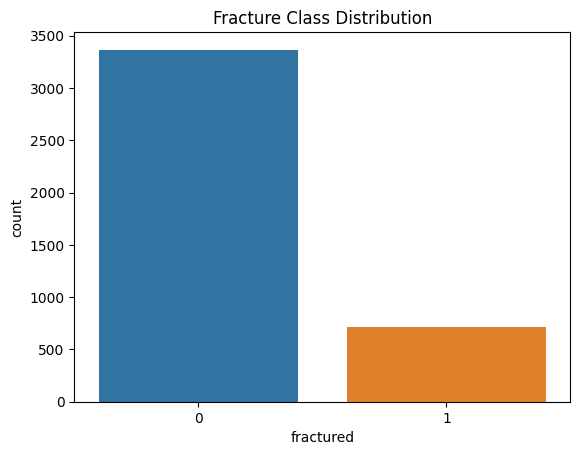

In [ ]:
fracture_counts = df['fractured'].value_counts()
print("\nClass distribution (0: Non-fractured, 1: Fractured):")
print(fracture_counts)

plt.figure()
sns.countplot(x='fractured', data=df)
plt.title('Fracture Class Distribution')
plt.show()


Body part distribution:
hand        1538
leg         2273
hip          338
shoulder     349
dtype: int64


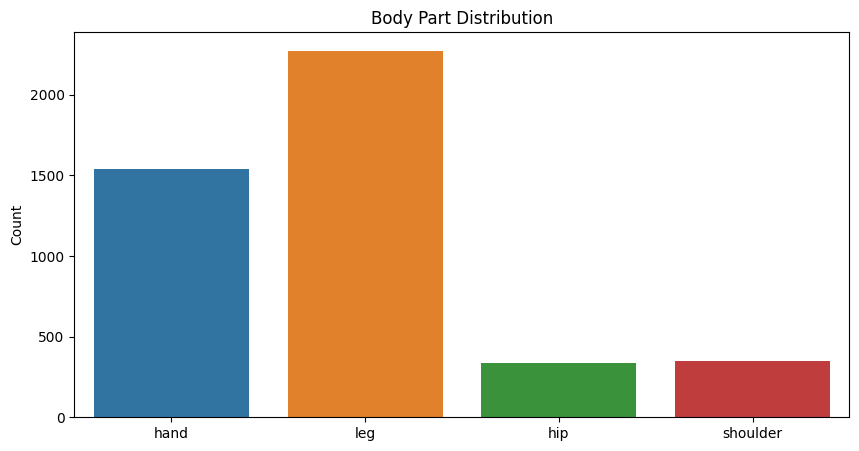


View distribution:
frontal    2503
lateral    1492
oblique     418
dtype: int64


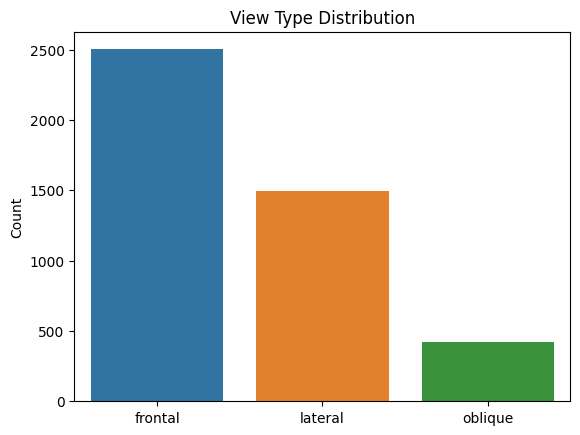

In [ ]:
body_parts = ['hand', 'leg', 'hip', 'shoulder']
body_part_counts = df[body_parts].sum()
print("\nBody part distribution:")
print(body_part_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=body_part_counts.index, y=body_part_counts.values)
plt.title('Body Part Distribution')
plt.ylabel('Count')
plt.show()

views = ['frontal', 'lateral', 'oblique']
view_counts = df[views].sum()
print("\nView distribution:")
print(view_counts)

plt.figure()
sns.barplot(x=view_counts.index, y=view_counts.values)
plt.title('View Type Distribution')
plt.ylabel('Count')
plt.show()

In [ ]:
hardware_counts = df['hardware'].value_counts()
print("\nHardware presence (0: Absent, 1: Present):")
print(hardware_counts)

multiscan_counts = df['multiscan'].value_counts()
print("\nMultiscan distribution (0: Single region, 1: Multiple regions):")
print(multiscan_counts)


Hardware presence (0: Absent, 1: Present):
hardware
0    3984
1      99
Name: count, dtype: int64

Multiscan distribution (0: Single region, 1: Multiple regions):
multiscan
0    3687
1     396
Name: count, dtype: int64



Fracture count distribution:
fracture_count
0    3366
1     546
2     146
3      17
4       7
5       1
Name: count, dtype: int64


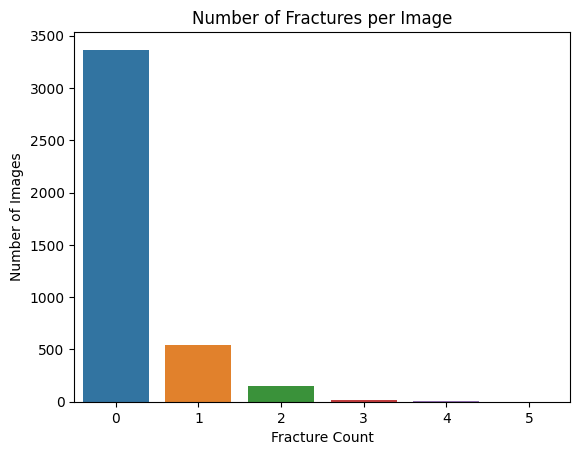

In [ ]:
fracture_num_counts = df['fracture_count'].value_counts().sort_index()
print("\nFracture count distribution:")
print(fracture_num_counts)

plt.figure()
sns.barplot(x=fracture_num_counts.index, y=fracture_num_counts.values)
plt.title('Number of Fractures per Image')
plt.xlabel('Fracture Count')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
image_id          0
hand              0
leg               0
hip               0
shoulder          0
mixed             0
hardware          0
multiscan         0
fractured         0
fracture_count    0
frontal           0
lateral           0
oblique           0
dtype: int64


In [ ]:
coco = COCO('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')
img_dir = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
image_id = 12

img = coco.imgs[image_id]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


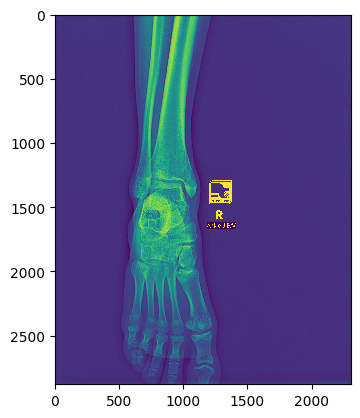

In [ ]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

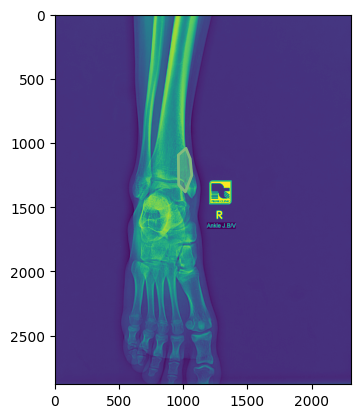

In [ ]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

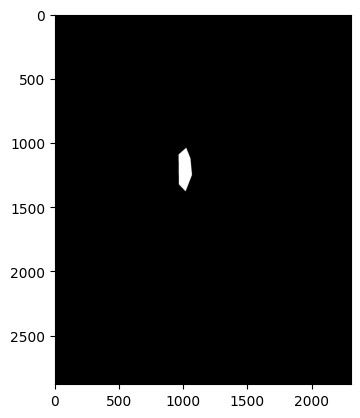

In [ ]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask,cmap='gray')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


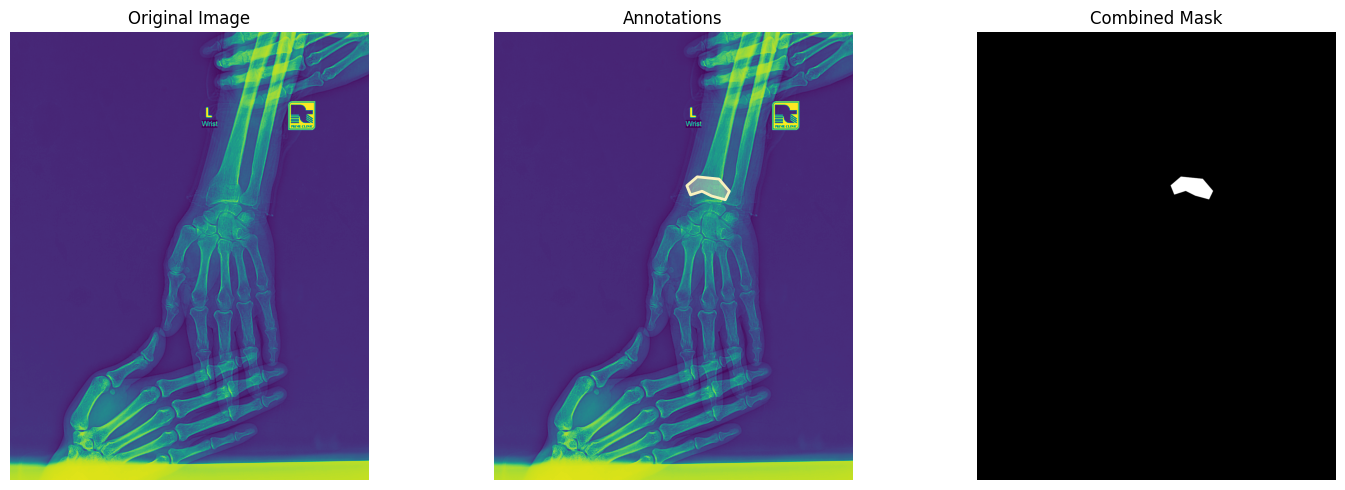

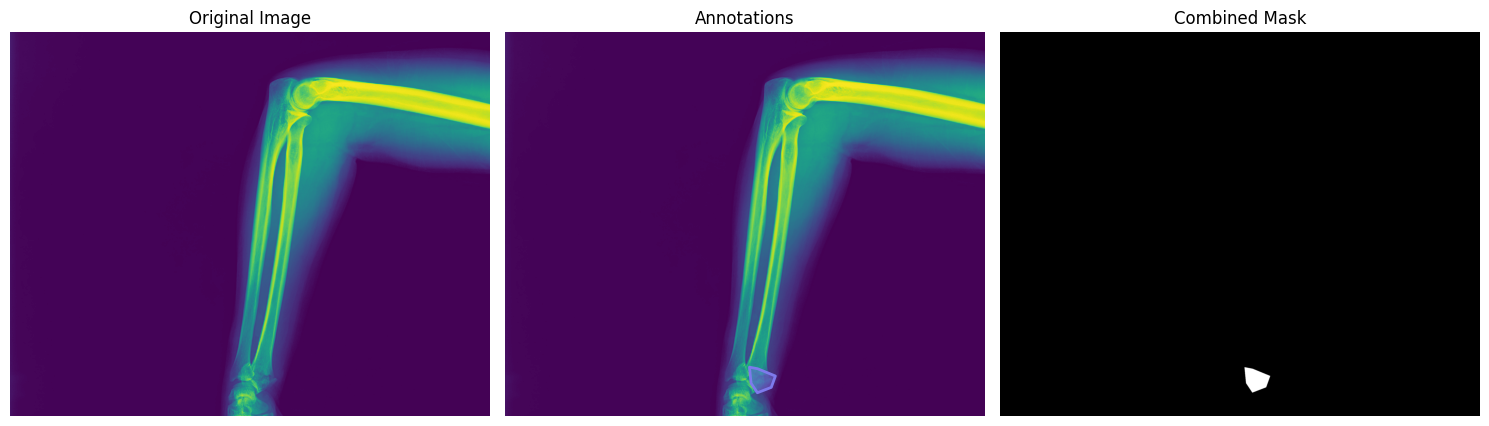

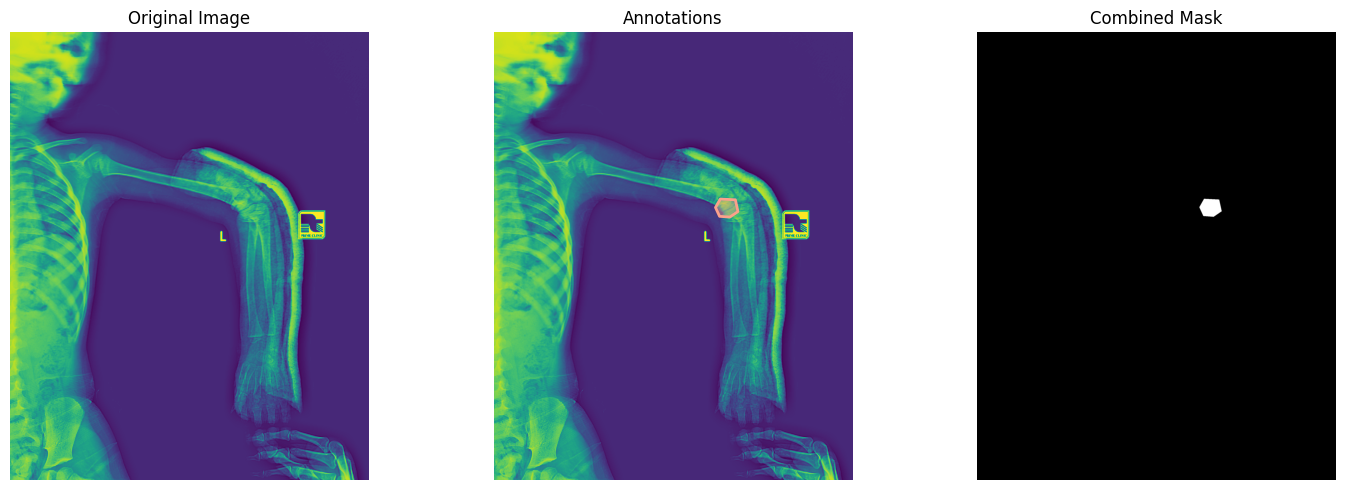

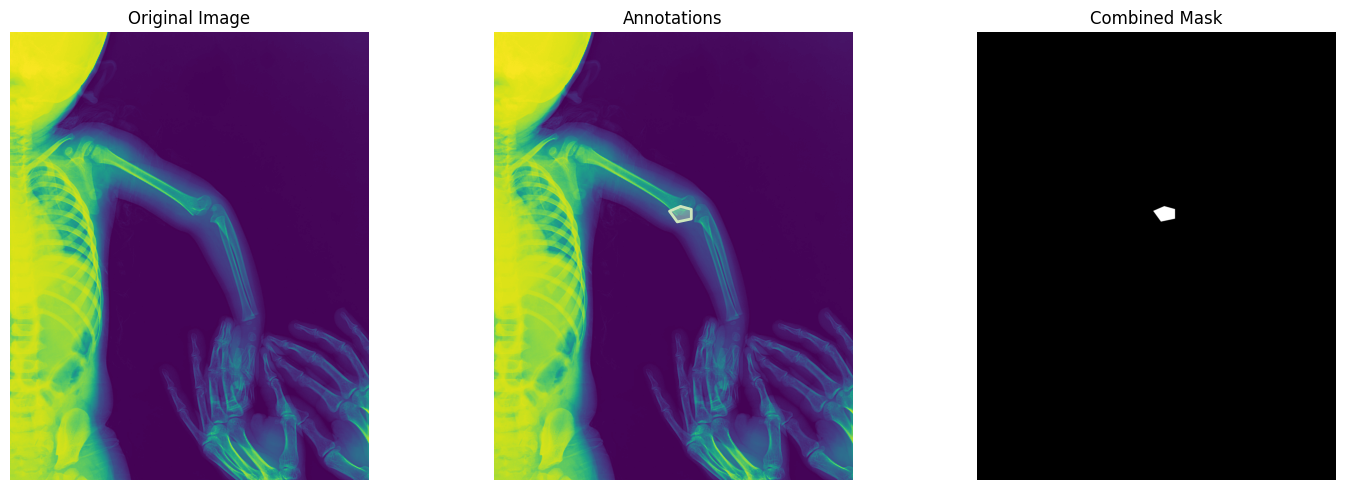

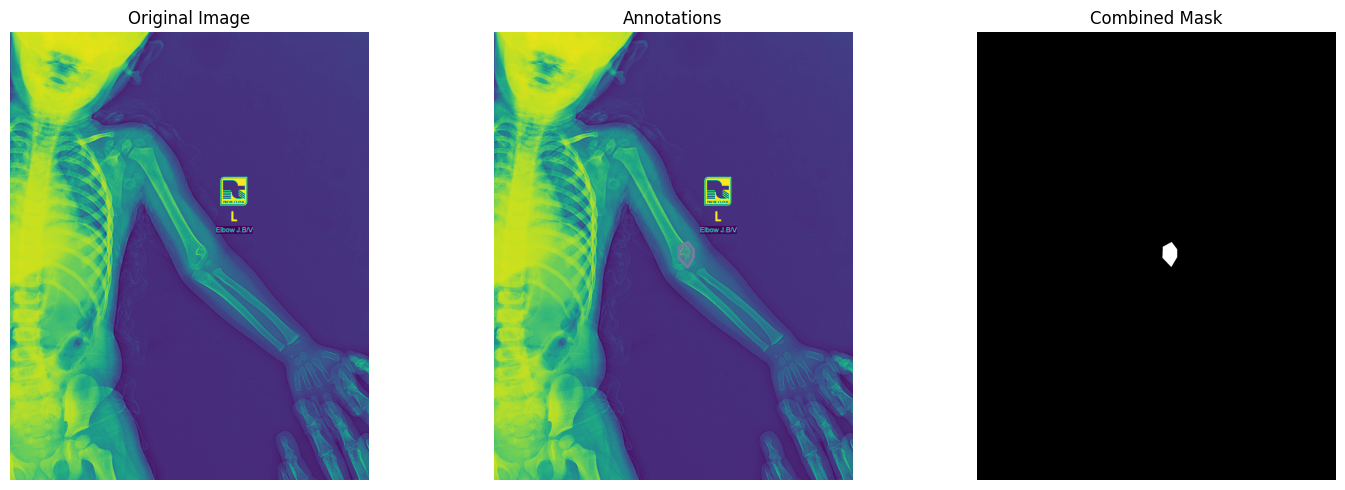

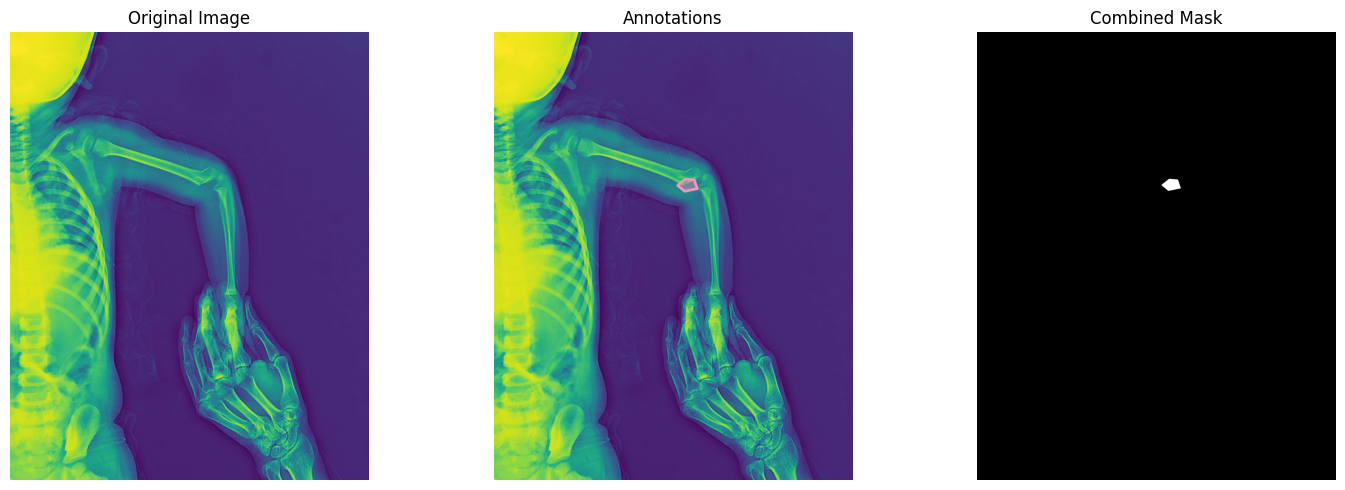

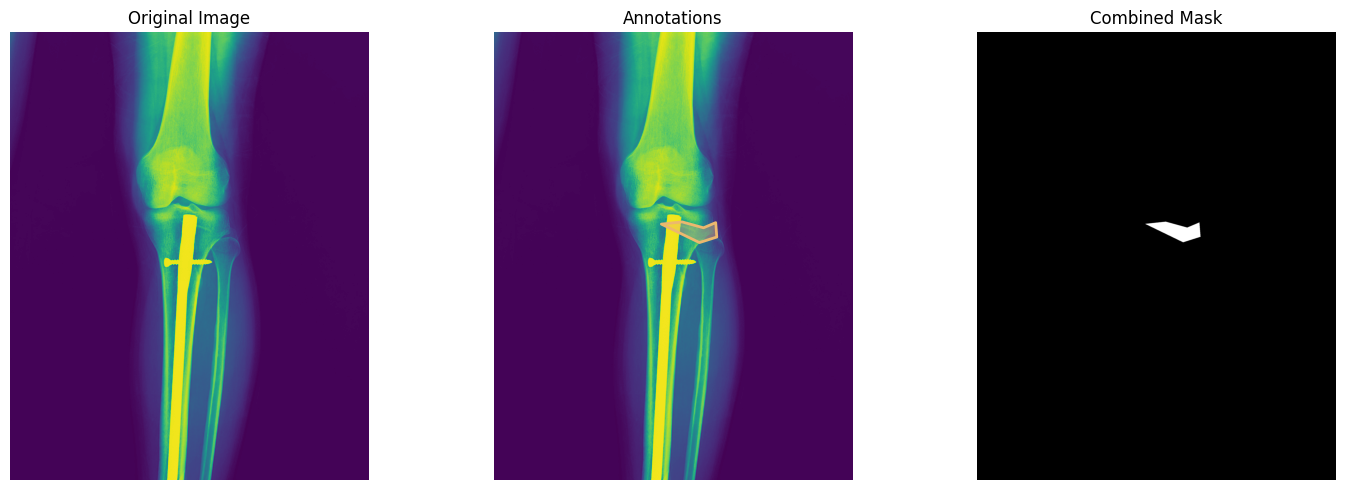

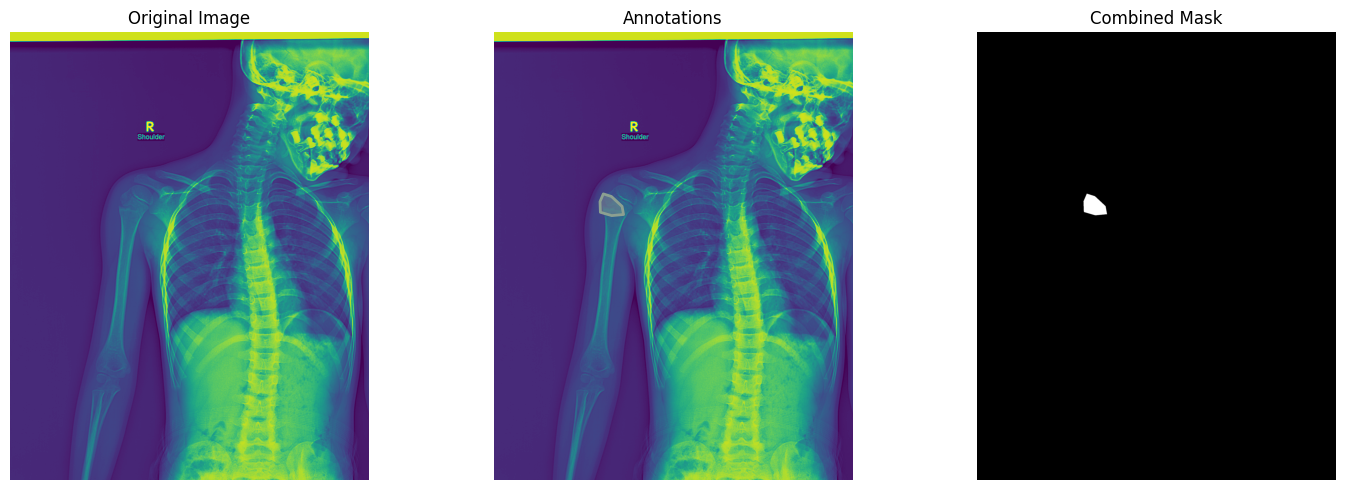

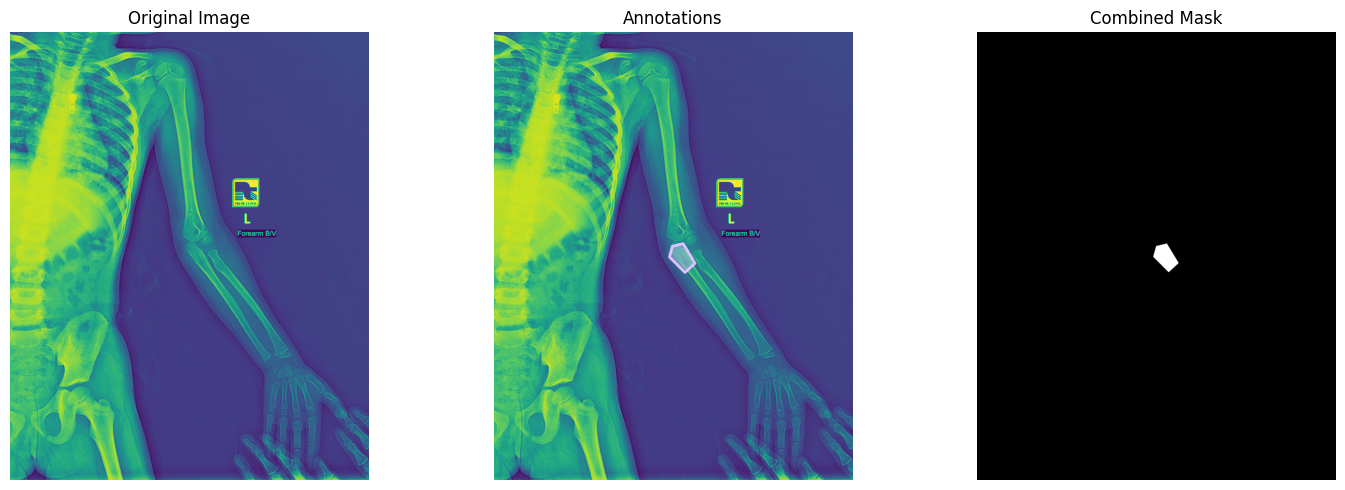

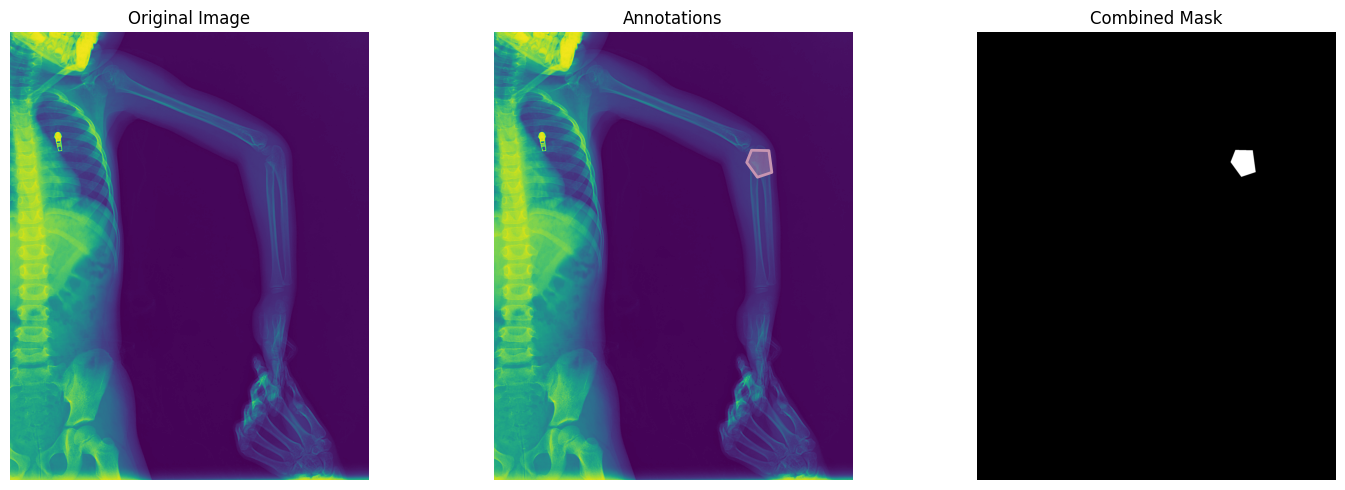

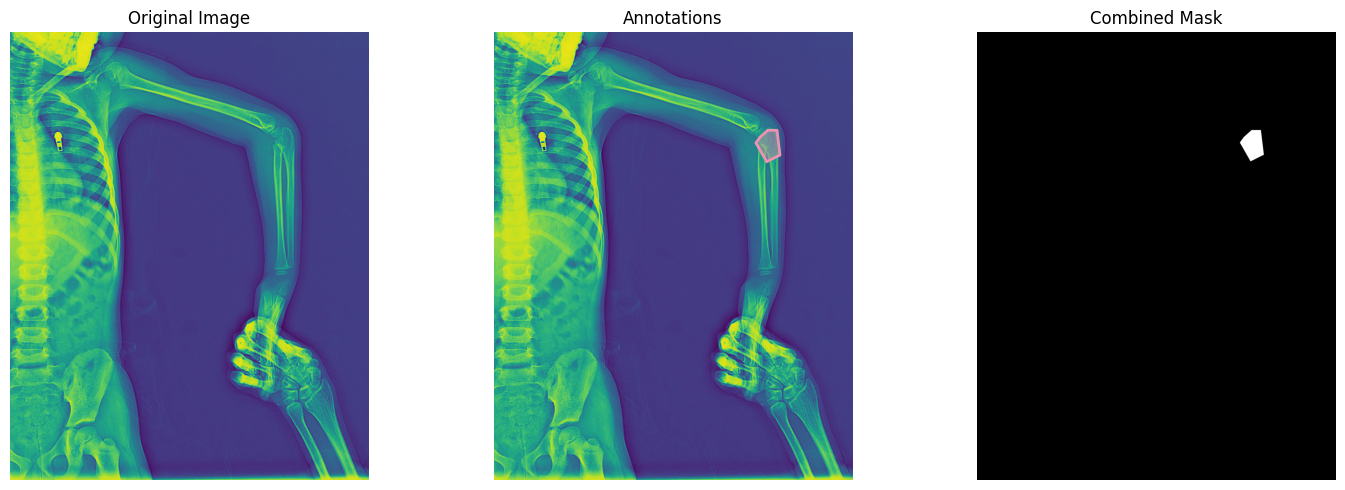

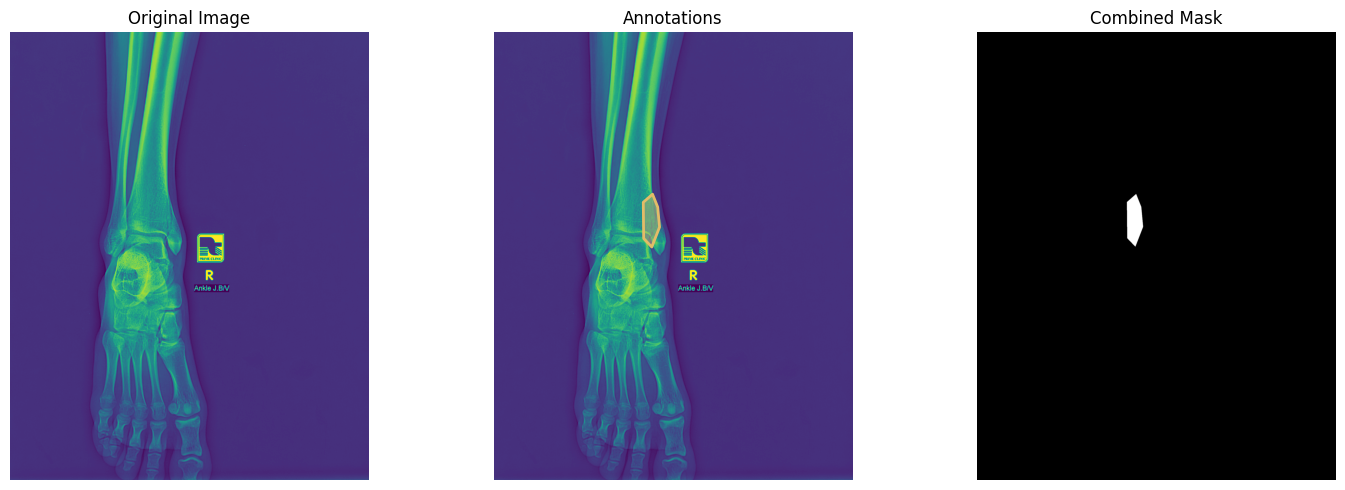

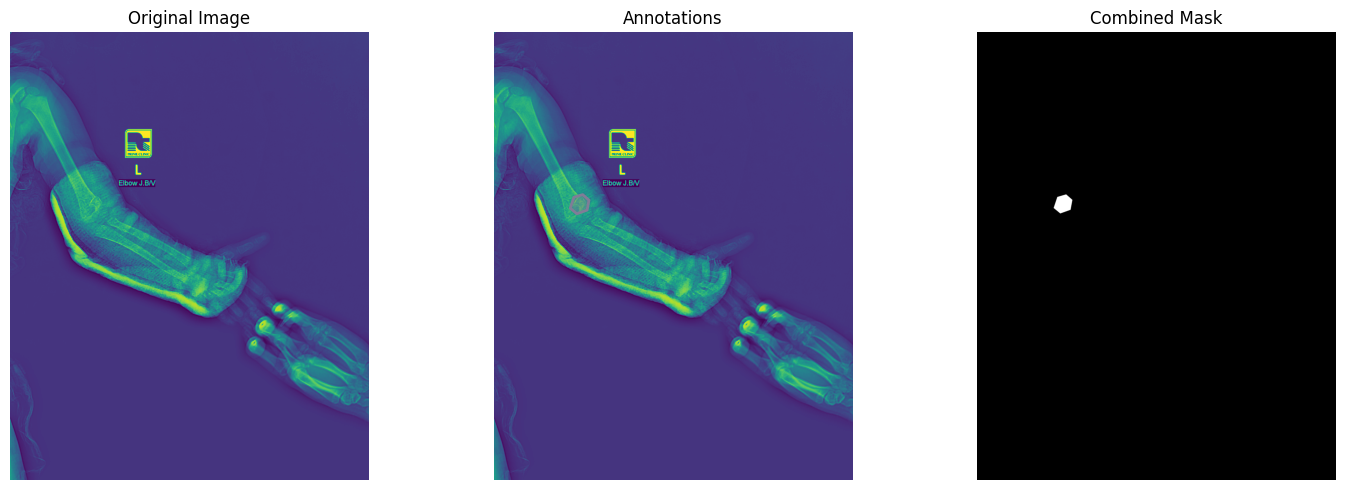

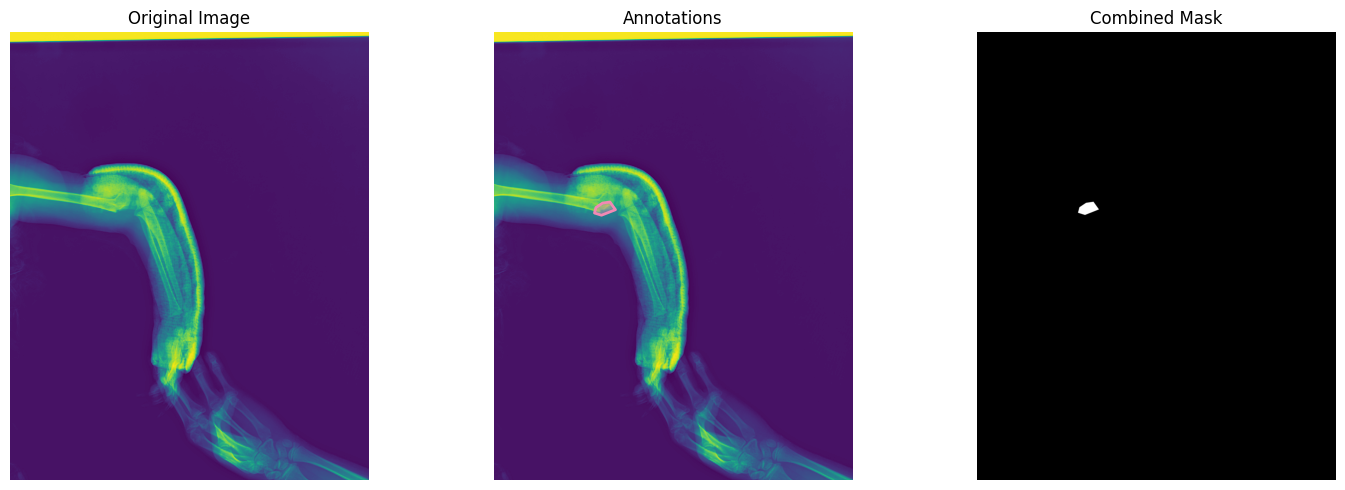

In [ ]:
coco = COCO('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')

img_dir = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
output_dir = '/kaggle/working/fracatlas/images/fractured_masks/'

os.makedirs(output_dir, exist_ok=True)

image_ids = coco.getImgIds()
num_images =14
for i in range(num_images):
    img = coco.loadImgs(image_ids[i])[0]
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))



    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    mask = coco.annToMask(anns[0])
    for j in range(1, len(anns)):
        mask += coco.annToMask(anns[j])

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')


    plt.subplot(1, 3, 2)
    plt.imshow(image)
    coco.showAnns(anns)
    plt.axis('off')
    plt.title('Annotations')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Combined Mask')

    plt.tight_layout()
    plt.show()

In [ ]:
image_folder_fractured = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
image_folder_non_fractured = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Non_fractured'
train_folder = '/kaggle/working/train'
val_folder = '/kaggle/working/val'
test_folder = '/kaggle/working/test'

os.makedirs(train_folder + '/fractured', exist_ok=True)
os.makedirs(train_folder + '/non_fractured', exist_ok=True)
os.makedirs(val_folder + '/fractured', exist_ok=True)
os.makedirs(val_folder + '/non_fractured', exist_ok=True)
os.makedirs(test_folder + '/fractured', exist_ok=True)
os.makedirs(test_folder + '/non_fractured', exist_ok=True)

def split_images(image_folder, train_folder, val_folder, test_folder, split_ratio=(0.8, 0.1, 0.1)):
    image_files = os.listdir(image_folder)
    random.shuffle(image_files)
    num_images = len(image_files)
    num_train = int(split_ratio[0] * num_images)
    num_val = int(split_ratio[1] * num_images)

    train_files = image_files[:num_train]
    val_files = image_files[num_train:num_train + num_val]
    test_files = image_files[num_train + num_val:]

    for file in train_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(train_folder, file))
    for file in val_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(val_folder, file))
    for file in test_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(test_folder, file))

split_images(image_folder_fractured, train_folder + '/fractured', val_folder + '/fractured', test_folder + '/fractured')
split_images(image_folder_non_fractured, train_folder + '/non_fractured', val_folder + '/non_fractured', test_folder + '/non_fractured')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_folder, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder(val_folder, transform=transform)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

DATASET_PATH = "/kaggle/input/fracatlas-original-dataset/FracAtlas"
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
CSV_PATH = os.path.join(DATASET_PATH, "dataset.csv")
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")

In [ ]:
df = pd.read_csv(CSV_PATH)

class BoneFractureDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(
            self.image_dir,
            "Fractured" if row['fractured'] == 1 else "Non_fractured",
            row['image_id']
        )
        try:
            image = Image.open(image_path).convert("RGB")
        except (OSError, IOError):
            return self[idx + 1 if idx + 1 < len(self) else 0]  # Get the next valid image

        label = row['fractured']

        if self.transform:
            image = self.transform(image)

        return image, float(label)

In [ ]:
fractured_0 = df[df['fractured'] == 0]  # Majority class
fractured_1 = df[df['fractured'] == 1]  # Minority class

fractured_0_undersampled = fractured_0.sample(n=len(fractured_1), random_state=42)

balanced_df = pd.concat([fractured_0_undersampled, fractured_1], axis=0).reset_index(drop=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_transform = T.Compose([T.Resize((384, 384)),
                             T.RandomHorizontalFlip(),
                             T.RandomRotation(10),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])

valid_transform = T.Compose([T.Resize((384, 384)),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])

In [ ]:
train_df, temp_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['fractured'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['fractured'], random_state=42)

train_dataset = BoneFractureDataset(train_df, IMAGES_PATH, transform=train_transform)
val_dataset = BoneFractureDataset(val_df, IMAGES_PATH, transform=valid_transform)
test_dataset = BoneFractureDataset(test_df, IMAGES_PATH, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
img, label = next(iter(train_loader))
img.shape, label

(torch.Size([8, 3, 384, 384]),
 tensor([1., 1., 1., 0., 1., 1., 0., 0.], dtype=torch.float64))

In [ ]:
import gc
gc.collect()

torch.cuda.empty_cache()

## **Part 1: Classification - Fracture Detection**

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b6')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:01<00:00, 118MB/s]  


Loaded pretrained weights for efficientnet-b6


In [ ]:
num_trainable_params(model)

40.740314

#### **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric1 = tm.Accuracy(task='multiclass', num_classes=2).to(device)
metric2 = tm.F1Score(task='multiclass', num_classes=2).to(device)
loss_fn, optimizer, metric1, metric2

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 MulticlassAccuracy(),
 MulticlassF1Score())

#### **Training**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric1, metric2, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric1.reset()
  metric2.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric1.update(outputs, targets)
      metric2.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, Accuracy=metric1.compute().item(), F1Score=metric2.compute().item())

  return model, loss_train.avg, metric1.compute().item(), metric2.compute().item()

#### **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric1, metric2):
  model.eval()
  loss_eval = AverageMeter()
  metric1.reset()
  metric2.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric1(outputs, targets)
      metric2(outputs, targets)

  return loss_eval.avg, metric1.compute().item(), metric2.compute().item()

#### **Main Loop**

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b6')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Loaded pretrained weights for efficientnet-b6


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric1 = tm.Accuracy(task='multiclass', num_classes=2).to(device)
metric2 = tm.F1Score(task='multiclass', num_classes=2).to(device)
loss_fn, optimizer, metric1, metric2

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 MulticlassAccuracy(),
 MulticlassF1Score())

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric1_train_hist = []
metric1_valid_hist = []

metric2_train_hist = []
metric2_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric1_train, metric2_train = train_one_epoch(model,
                                                                    train_loader,
                                                                    loss_fn,
                                                                    optimizer,
                                                                    metric1,
                                                                    metric2,
                                                                    epoch)
  # Validation
  loss_valid, metric1_valid, metric2_valid = evaluate(model,
                                                      valid_loader,
                                                      loss_fn,
                                                      metric1,
                                                      metric2)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric1_train_hist.append(metric1_train)
  metric1_valid_hist.append(metric1_valid)

  metric2_train_hist.append(metric2_train)
  metric2_valid_hist.append(metric2_valid)

  print(f'Valid: Loss = {loss_valid:.4}, Accuracy = {metric1_valid:.4}, F1Score = {metric2_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, f'/kaggle/working/model_effnet.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 246/246 [02:12<00:00,  1.86batch/s, Accuracy=0.828, F1Score=0.828, loss=0.408]


Valid: Loss = 0.4627, Accuracy = 0.8288, F1Score = 0.8288
Model Saved!



Epoch 1: 100%|██████████| 246/246 [02:12<00:00,  1.86batch/s, Accuracy=0.869, F1Score=0.869, loss=0.326]


Valid: Loss = 0.3379, Accuracy = 0.8945, F1Score = 0.8945
Model Saved!



Epoch 2: 100%|██████████| 246/246 [02:12<00:00,  1.85batch/s, Accuracy=0.891, F1Score=0.891, loss=0.282]


Valid: Loss = 0.262, Accuracy = 0.9228, F1Score = 0.9228
Model Saved!



Epoch 3: 100%|██████████| 246/246 [02:12<00:00,  1.85batch/s, Accuracy=0.915, F1Score=0.915, loss=0.233]


Valid: Loss = 0.265, Accuracy = 0.9151, F1Score = 0.9151



Epoch 4: 100%|██████████| 246/246 [02:13<00:00,  1.85batch/s, Accuracy=0.925, F1Score=0.925, loss=0.206]


Valid: Loss = 0.179, Accuracy = 0.9447, F1Score = 0.9447
Model Saved!



Epoch 5: 100%|██████████| 246/246 [02:14<00:00,  1.83batch/s, Accuracy=0.942, F1Score=0.942, loss=0.164]


Valid: Loss = 0.132, Accuracy = 0.9485, F1Score = 0.9485
Model Saved!



Epoch 6: 100%|██████████| 246/246 [02:13<00:00,  1.84batch/s, Accuracy=0.955, F1Score=0.955, loss=0.124]


Valid: Loss = 0.1185, Accuracy = 0.9678, F1Score = 0.9678
Model Saved!



Epoch 7: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.962, F1Score=0.962, loss=0.108] 


Valid: Loss = 0.1512, Accuracy = 0.9562, F1Score = 0.9562



Epoch 8: 100%|██████████| 246/246 [02:13<00:00,  1.84batch/s, Accuracy=0.966, F1Score=0.966, loss=0.0979]


Valid: Loss = 0.104, Accuracy = 0.9665, F1Score = 0.9665
Model Saved!



Epoch 9: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.975, F1Score=0.975, loss=0.0719]


Valid: Loss = 0.1594, Accuracy = 0.9691, F1Score = 0.9691



Epoch 10: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.978, F1Score=0.978, loss=0.0639]


Valid: Loss = 0.1419, Accuracy = 0.9717, F1Score = 0.9717



Epoch 11: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.978, F1Score=0.978, loss=0.0649]


Valid: Loss = 0.05717, Accuracy = 0.982, F1Score = 0.982
Model Saved!



Epoch 12: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.976, F1Score=0.976, loss=0.0627]


Valid: Loss = 0.05924, Accuracy = 0.982, F1Score = 0.982



Epoch 13: 100%|██████████| 246/246 [02:13<00:00,  1.84batch/s, Accuracy=0.986, F1Score=0.986, loss=0.0383]


Valid: Loss = 0.08161, Accuracy = 0.9781, F1Score = 0.9781



Epoch 14: 100%|██████████| 246/246 [02:14<00:00,  1.82batch/s, Accuracy=0.982, F1Score=0.982, loss=0.0558]


Valid: Loss = 0.06205, Accuracy = 0.982, F1Score = 0.982



Epoch 15: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.99, F1Score=0.99, loss=0.0326]  


Valid: Loss = 0.08237, Accuracy = 0.9781, F1Score = 0.9781



Epoch 16: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.987, F1Score=0.987, loss=0.0404]


Valid: Loss = 0.08095, Accuracy = 0.9833, F1Score = 0.9833



Epoch 17: 100%|██████████| 246/246 [02:15<00:00,  1.82batch/s, Accuracy=0.985, F1Score=0.985, loss=0.048] 


Valid: Loss = 0.1655, Accuracy = 0.9485, F1Score = 0.9485



Epoch 18: 100%|██████████| 246/246 [02:13<00:00,  1.84batch/s, Accuracy=0.99, F1Score=0.99, loss=0.0337]  


Valid: Loss = 0.1027, Accuracy = 0.973, F1Score = 0.973



Epoch 19: 100%|██████████| 246/246 [02:14<00:00,  1.83batch/s, Accuracy=0.994, F1Score=0.994, loss=0.0214]


Valid: Loss = 0.1178, Accuracy = 0.9627, F1Score = 0.9627



#### Plot Learning Curve

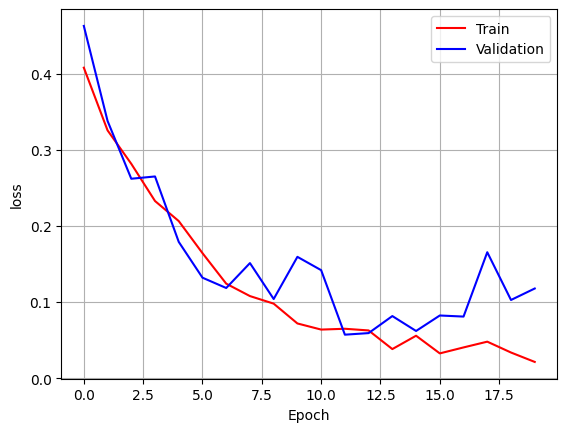

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

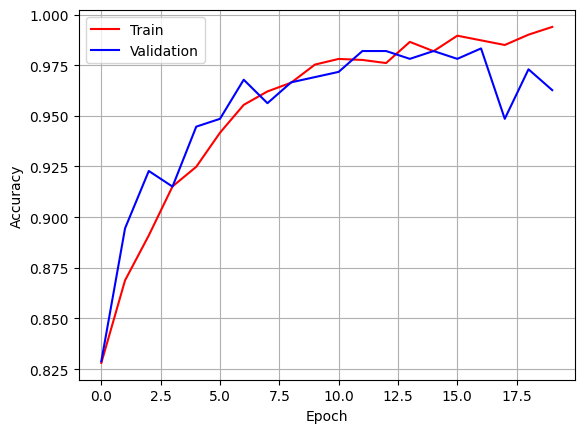

In [ ]:
plt.plot(range(epoch_counter), metric1_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric1_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

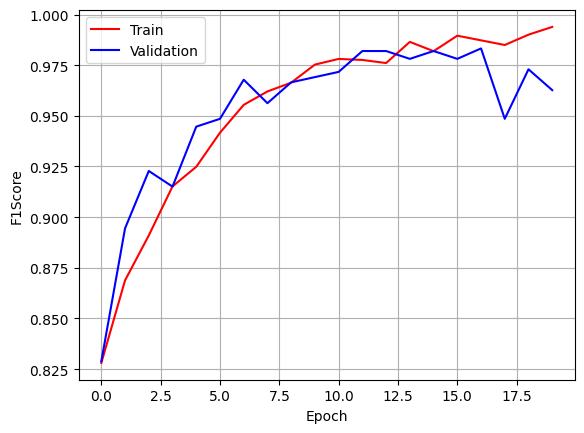

In [ ]:
plt.plot(range(epoch_counter), metric1_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric1_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('F1Score')
plt.grid(True)
plt.legend()
plt.show()

#### **Test**

In [ ]:
best_model = torch.load(f'/kaggle/working/model_effnet.pt')

In [ ]:
torch.save(best_model.state_dict(), '/kaggle/working/model_effnet_state_dict.pth')

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b6')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = model.to(device)

Loaded pretrained weights for efficientnet-b6


In [ ]:
best_model.load_state_dict(torch.load('/kaggle/input/effnet/model_effnet_state_dict.pth'))
best_model.eval()

In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt


best_model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)

        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [ ]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)


auc = roc_auc_score(all_labels, all_probs)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")

Precision: 0.98
Recall: 0.99
F1 Score: 0.99
Accuracy: 0.99
AUC: 0.99


Confusion Matrix:
[[129  10]
 [  4 639]]


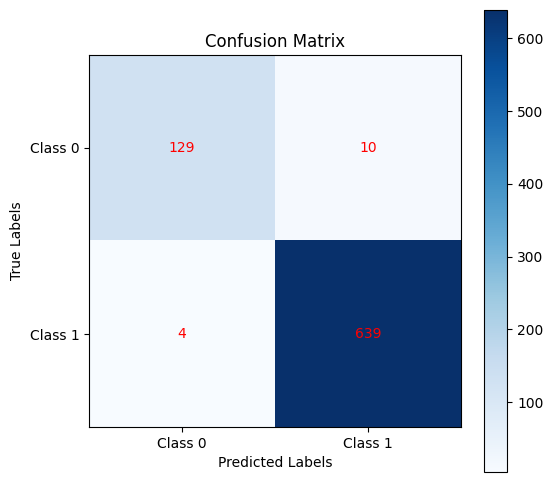

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.show()

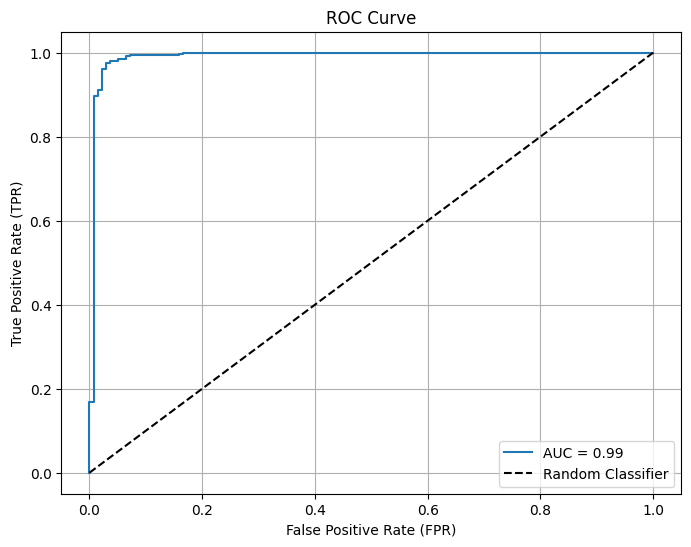

In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
import pandas as pd

metrics = {
    "Metric": ["Precision", "Recall", "F1 Score", "Accuracy", "AUC"],
    "Value": [precision, recall, f1, accuracy, auc]
}

metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df.to_csv("metrics.csv", index=False)

##  **Part 2: Segmentation**

### **Methodology:**

#### **Dataset and Preprocessing**:
The dataset consisted of:
- **Images:** Located in the directory `images/Fractured`, containing medical images with fractured regions.
- **Annotations:** Provided in COCO JSON format (`COCO_fracture_masks.json`), detailing polygon-based masks for fractured regions.

The dataset was parsed using the `pycocotools` library, and masks were converted from COCO annotations using the `coco.annToMask` method.

#### **Model Selection:**
- **Model Used:** Segment Anything Model (SAM)
  - **Model Type:** `vit_h`
  - **Checkpoint:** `sam_vit_h_4b8939.pth`
- The SAM model was initialized and configured to run on GPU (if available) for efficient inference.

#### **Segmentation Pipeline:**
1. **Image Loading:** Each image was loaded using OpenCV and converted to RGB format.
2. **Annotation Retrieval:** Annotations corresponding to each image were loaded using their image ID.
3. **Ground Truth Mask Generation:** COCO annotations were converted to binary masks.
4. **Bounding Box Extraction:** Bounding boxes were extracted from COCO annotations and used as prompts for SAM.
5. **Prediction:** SAM predicted masks for the input bounding boxes.

#### **Evaluation Metrics:**
- **Intersection over Union (IoU):** Measures the overlap between ground truth and predicted masks.
- **Precision:** The fraction of true positive pixels out of all predicted positive pixels.
- **Recall:** The fraction of true positive pixels out of all ground truth positive pixels.

#### **Visualization:**
- Overlays were created to visualize:
  - Ground truth masks (red overlay).
  - Predicted masks (green overlay).
  - Bounding boxes (blue).
- Visualizations were displayed for every 50th image to provide insight into the segmentation performance.

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-01-24 13:10:23--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.128, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   278MB/s    in 8.8s    

2025-01-24 13:10:32 (279 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from sklearn.metrics import jaccard_score, precision_score, recall_score
from segment_anything import sam_model_registry, SamPredictor
import torch

In [ ]:
data_root = "/kaggle/input/fracatlas-original-dataset/FracAtlas"
images_path = os.path.join(data_root, "images/Fractured")
annotations_path = os.path.join(data_root, "Annotations/COCO JSON")
coco_json_path = os.path.join(annotations_path, "COCO_fracture_masks.json")

In [ ]:
coco = COCO(coco_json_path)
image_ids = coco.getImgIds()
category_ids = coco.getCatIds()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
def coco_to_mask(coco, annotation, img_shape):
    mask = coco.annToMask(annotation)
    return cv2.resize(mask, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)

In [ ]:
def evaluate_segmentation(gt_mask, pred_mask):
    iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten(), average="binary")
    precision = precision_score(gt_mask.flatten(), pred_mask.flatten())
    recall = recall_score(gt_mask.flatten(), pred_mask.flatten())
    return iou, precision, recall

In [ ]:
def visualize_overlays(image, gt_mask, pred_mask, bbox, image_id):
    gt_overlay = image.copy()
    pred_overlay = image.copy()
    bbox_overlay = image.copy()

    gt_overlay[gt_mask > 0] = [255, 0, 0]

    pred_overlay[pred_mask > 0] = [0, 255, 0]

    bbox_overlay[gt_mask > 0] = [255, 0, 0]  # Ground truth in red
    bbox_overlay[pred_mask > 0] = [0, 255, 0]  # Prediction in green

    x1, y1, x2, y2 = map(int, bbox)
    cv2.rectangle(bbox_overlay, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue box

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[1].imshow(gt_overlay)
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(pred_overlay)
    axes[2].set_title("Predicted Mask")
    axes[3].imshow(bbox_overlay)
    axes[3].set_title("BBox (Blue) + GT + Pred")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
iou_scores = []
precision_scores = []
recall_scores = []

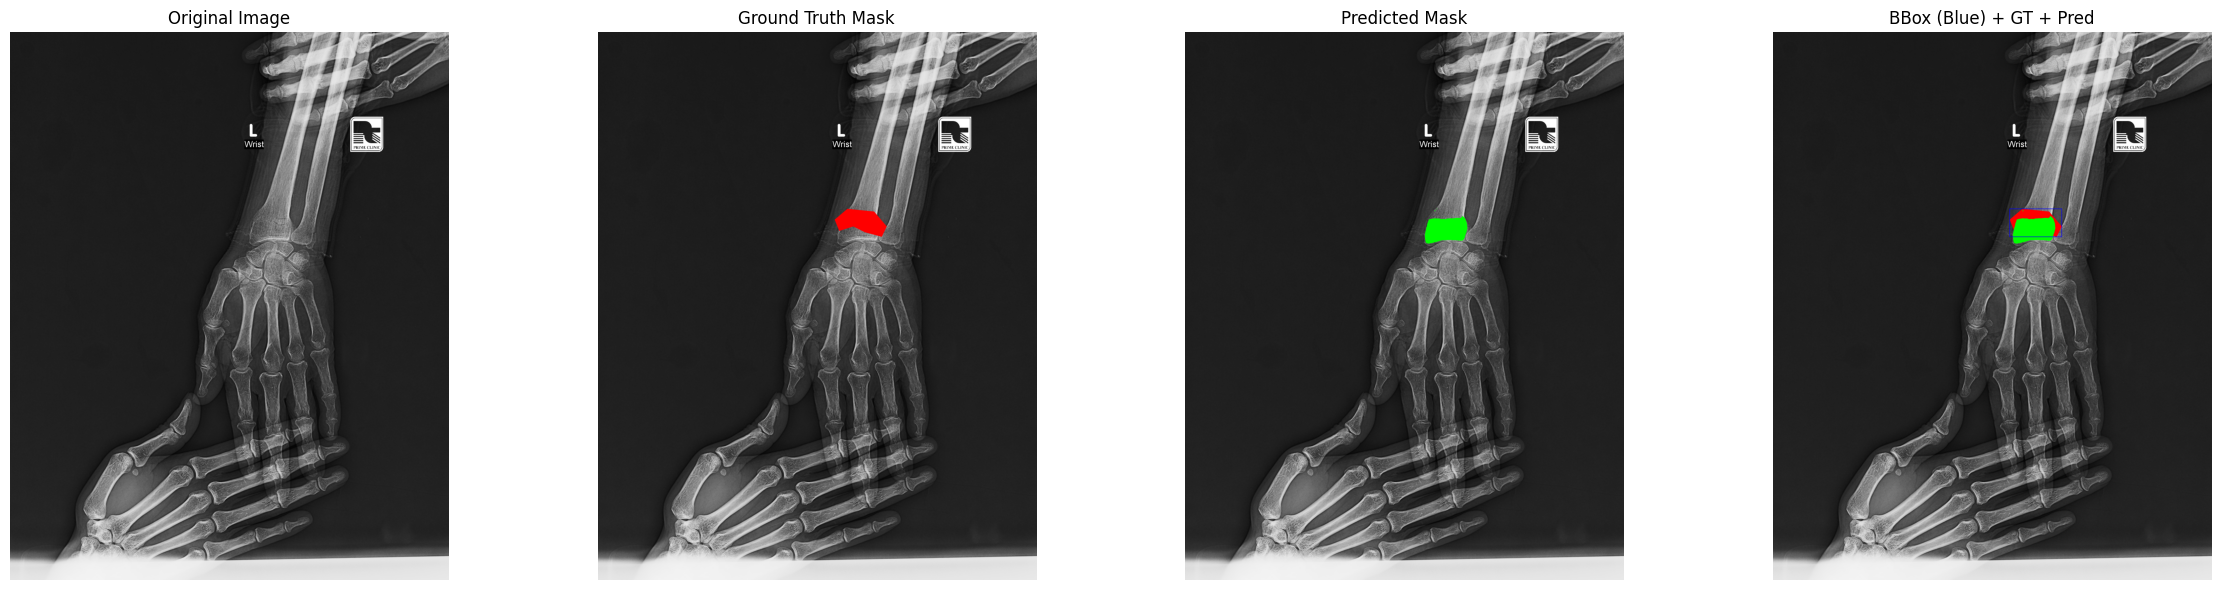

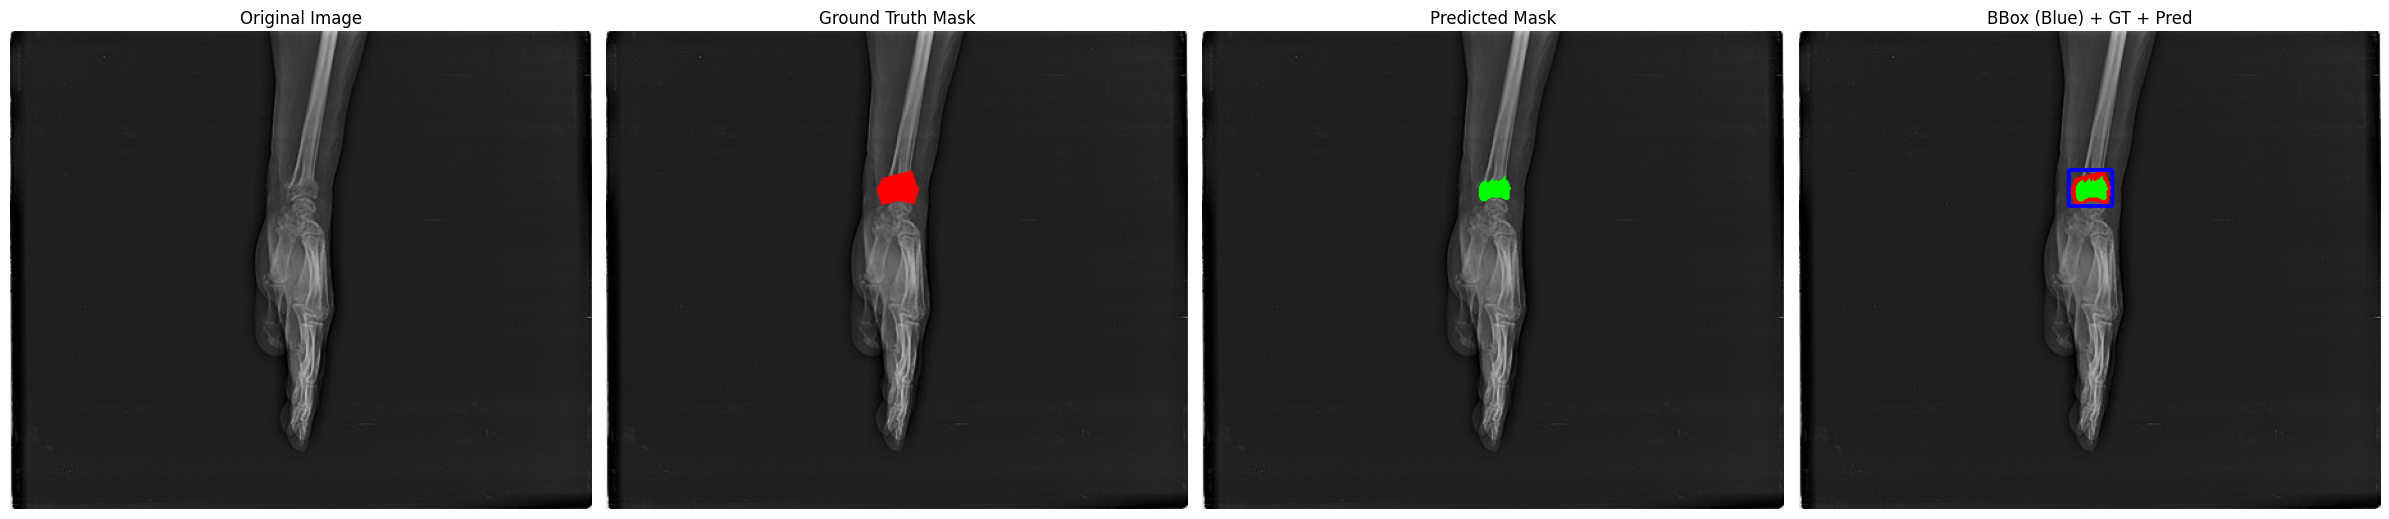

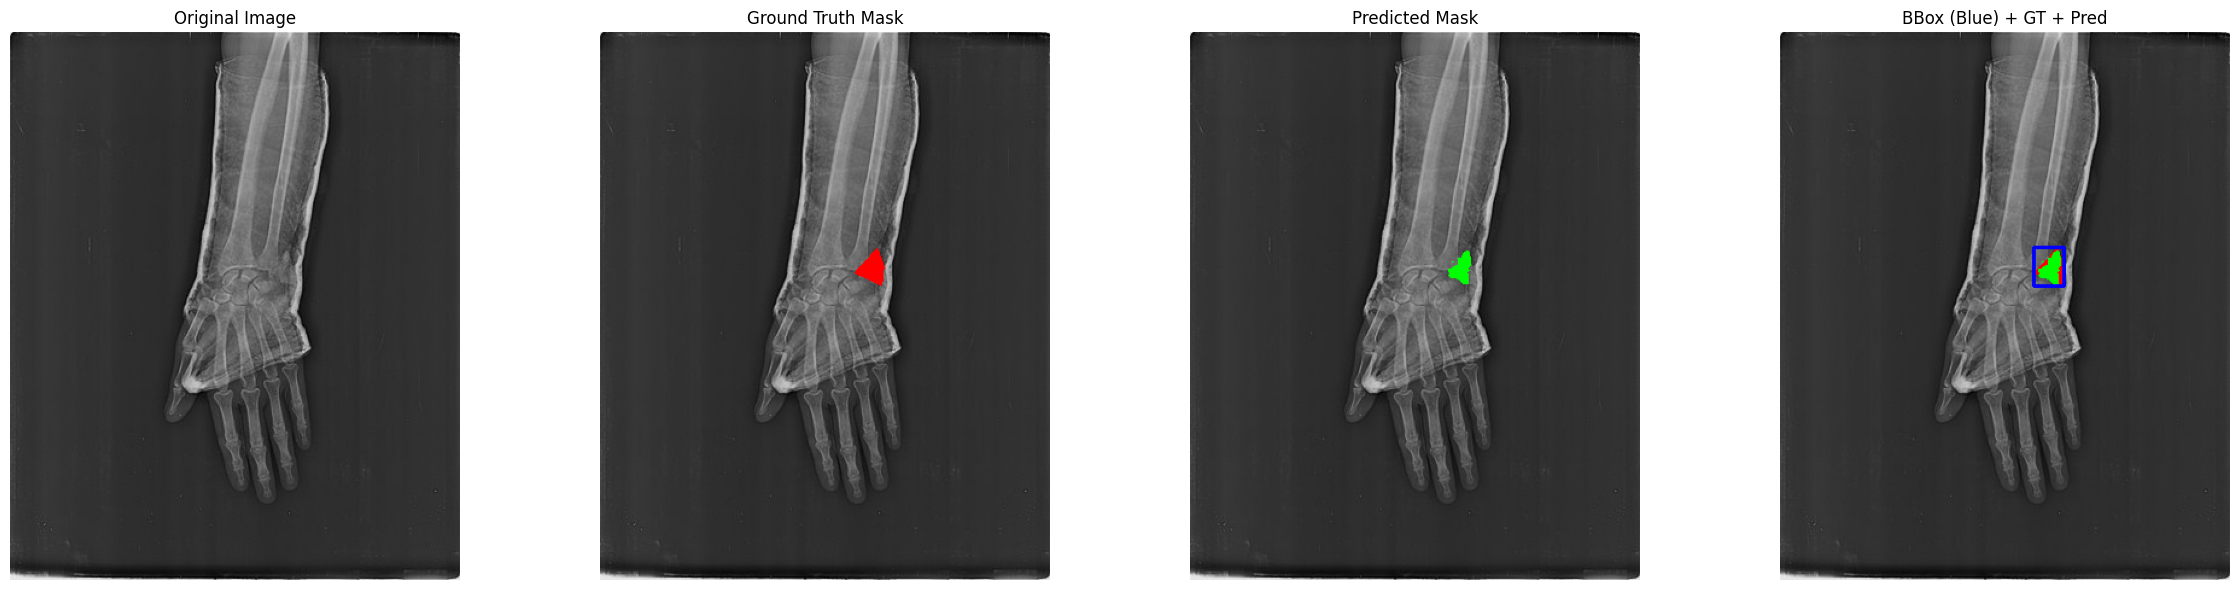

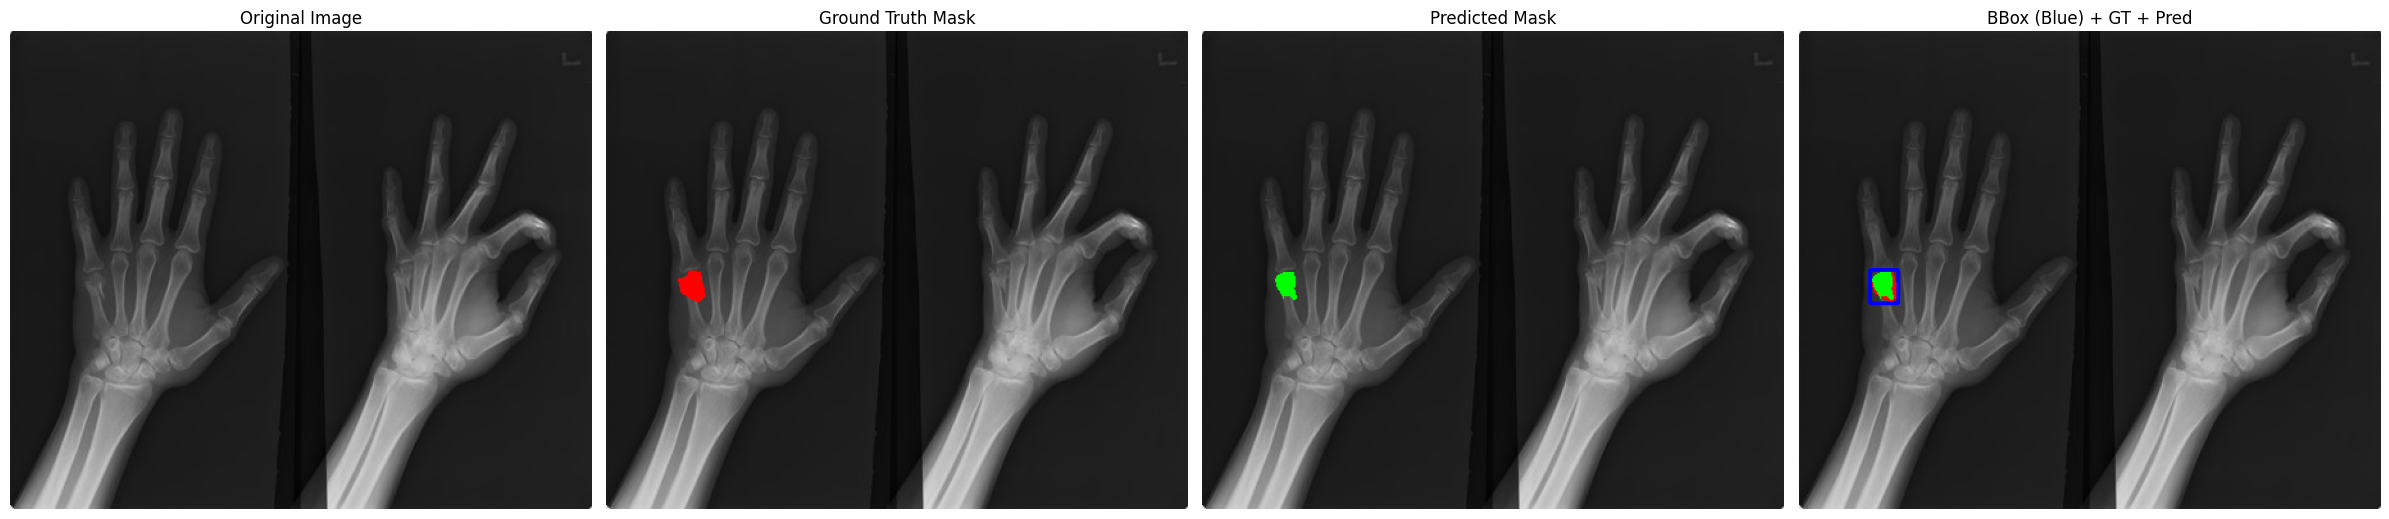

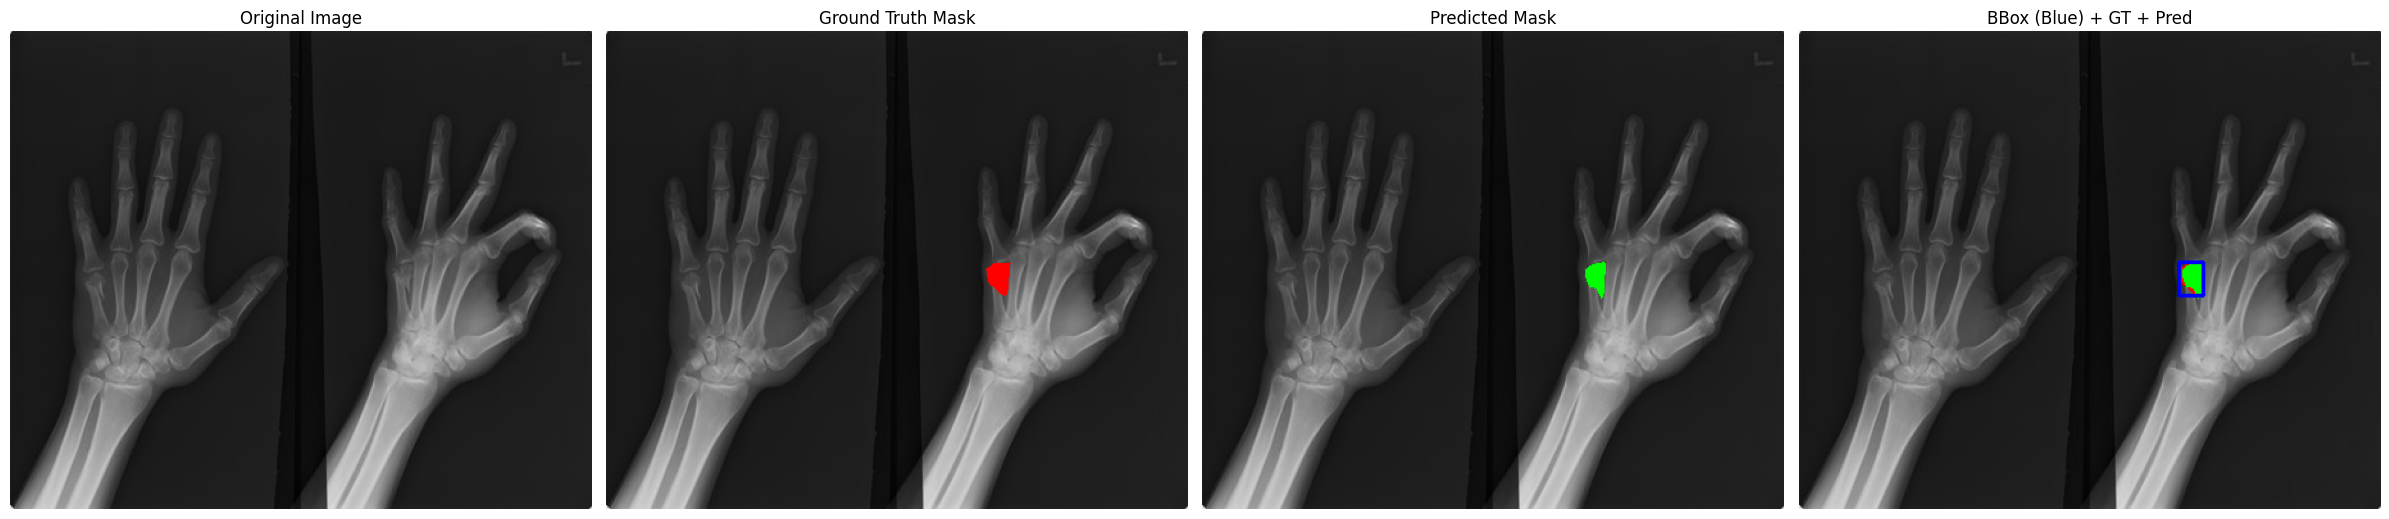

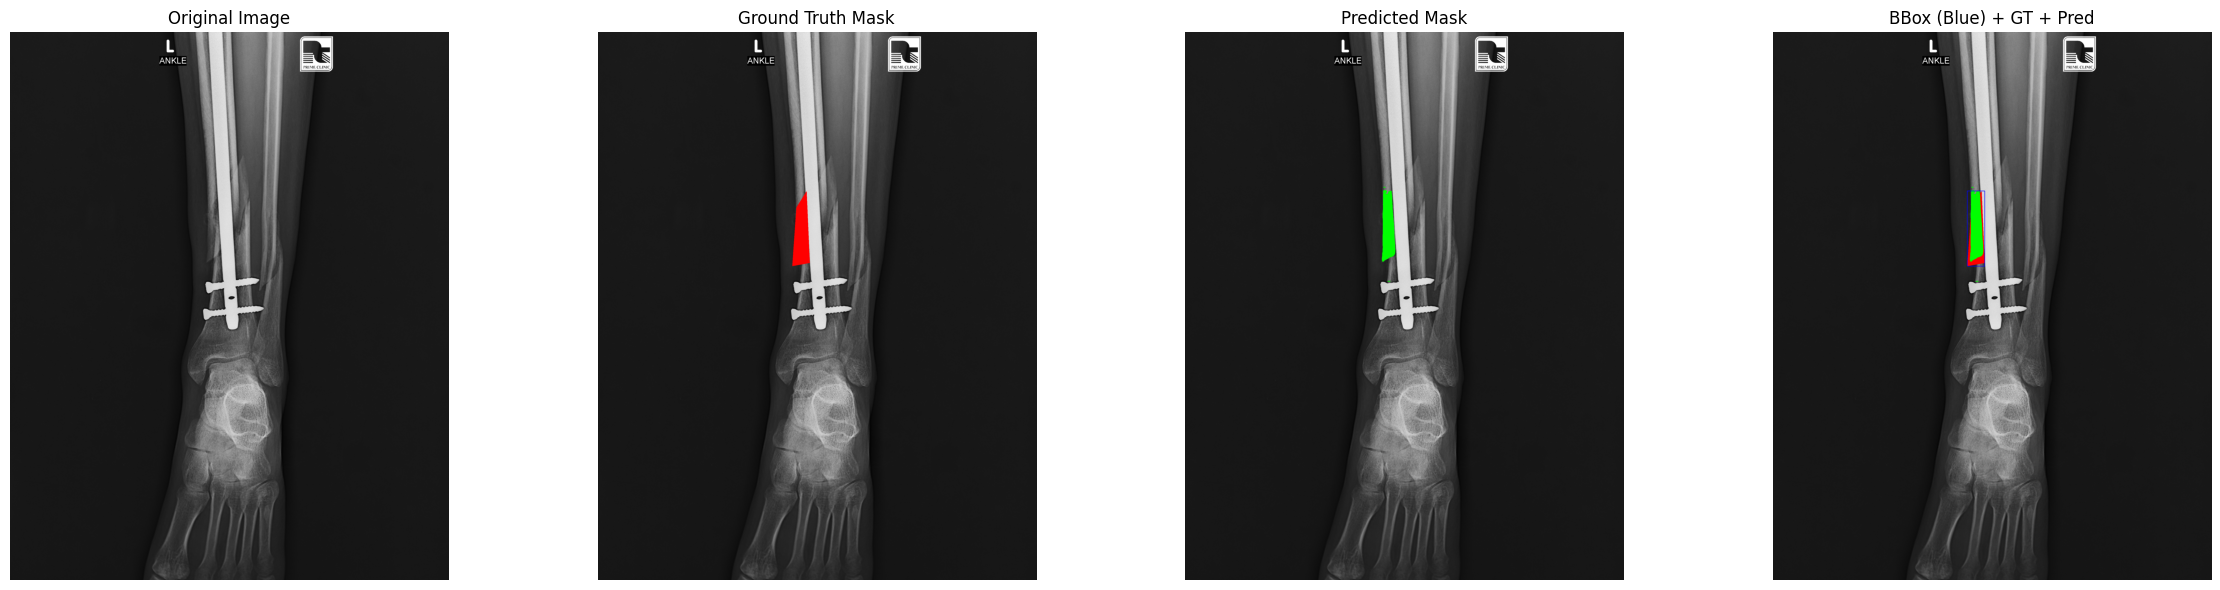

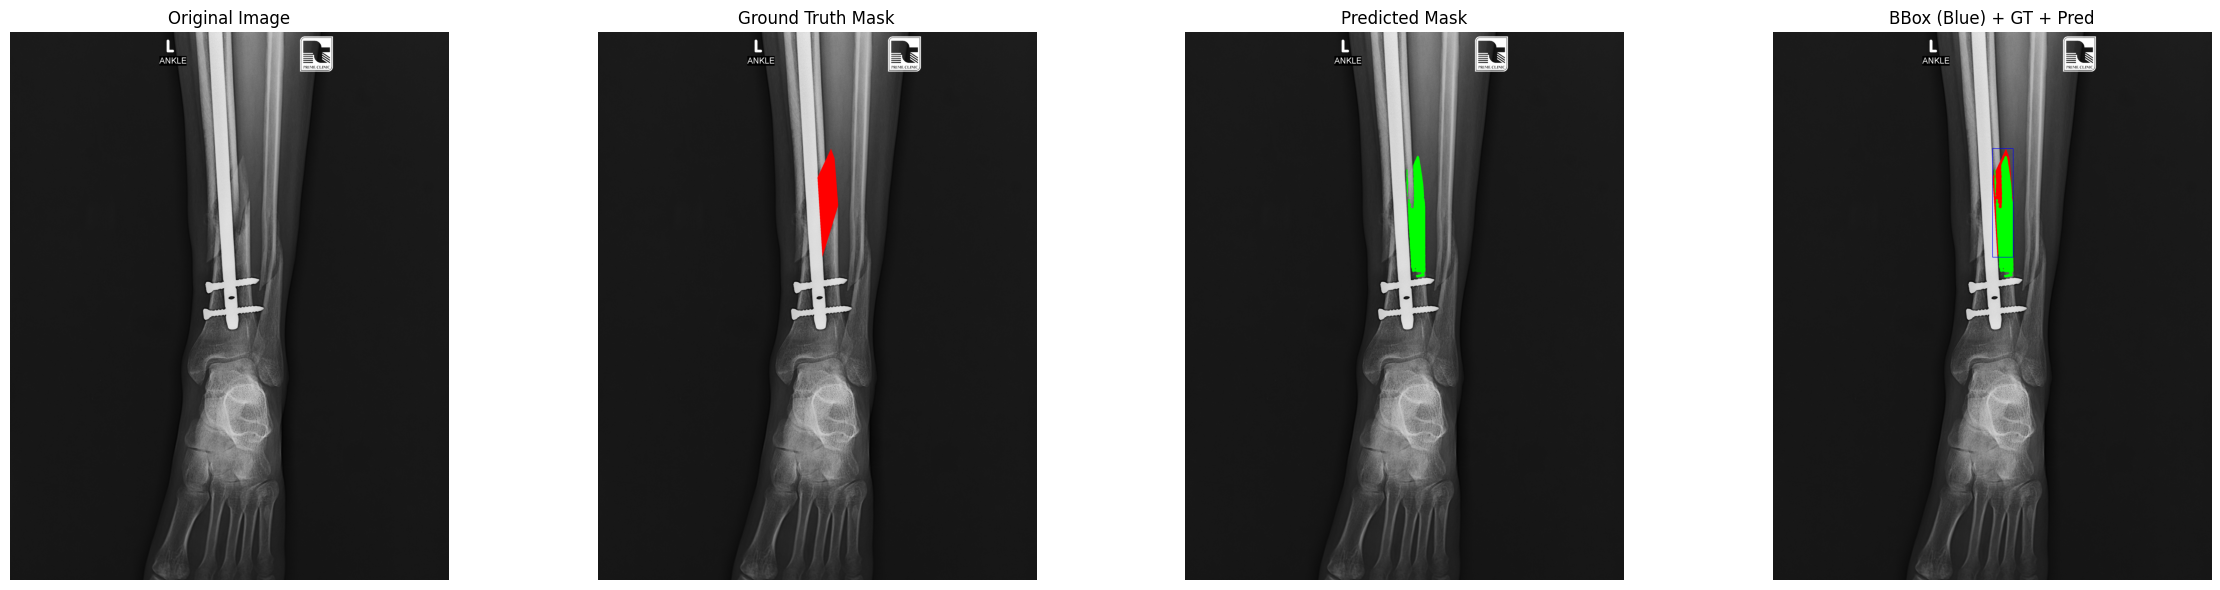

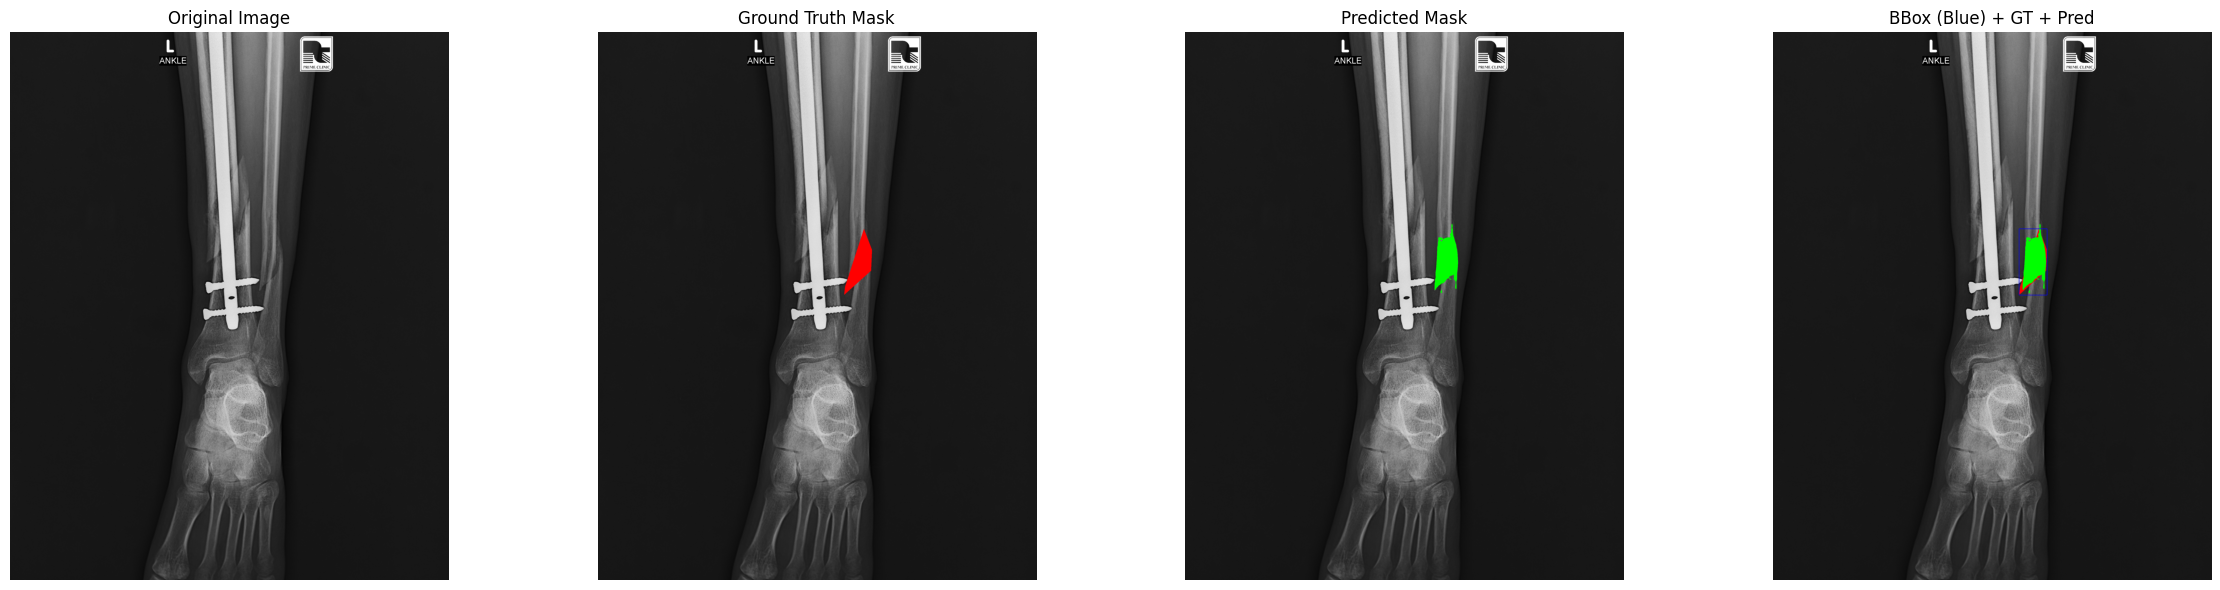

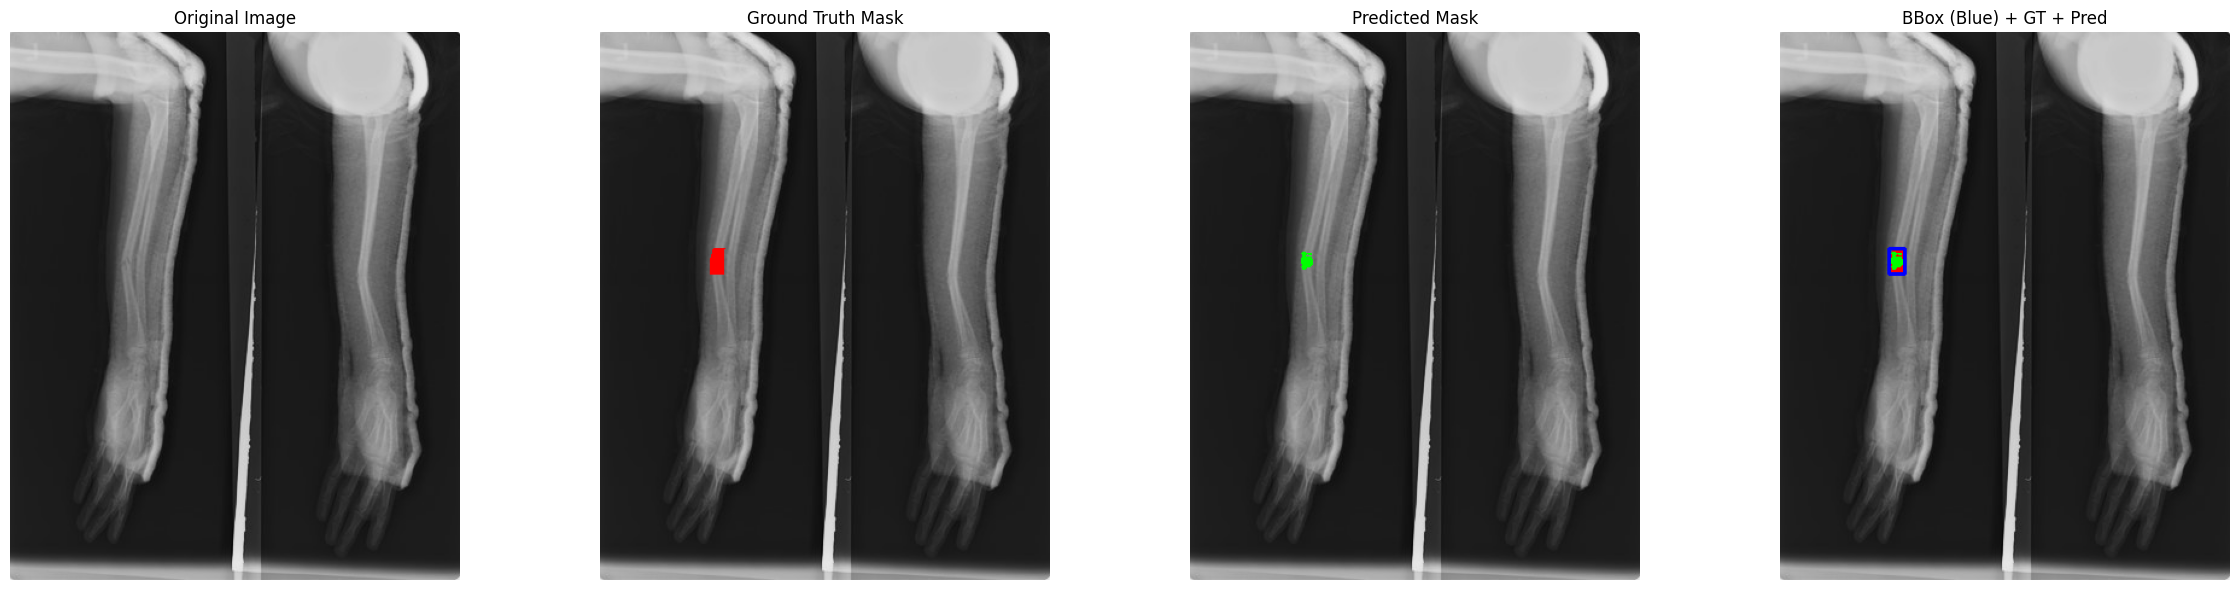

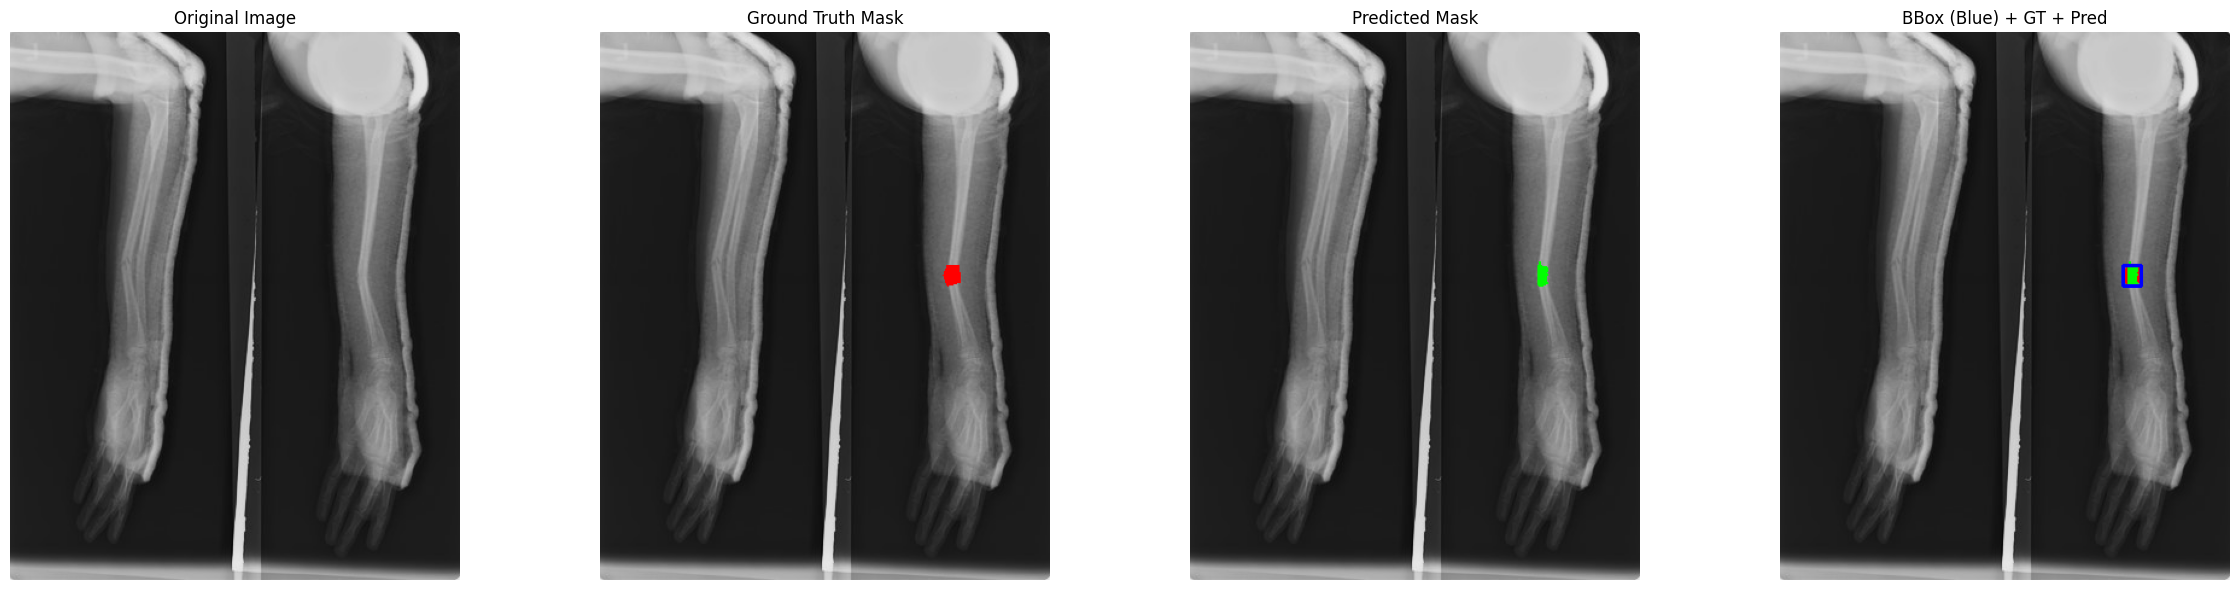

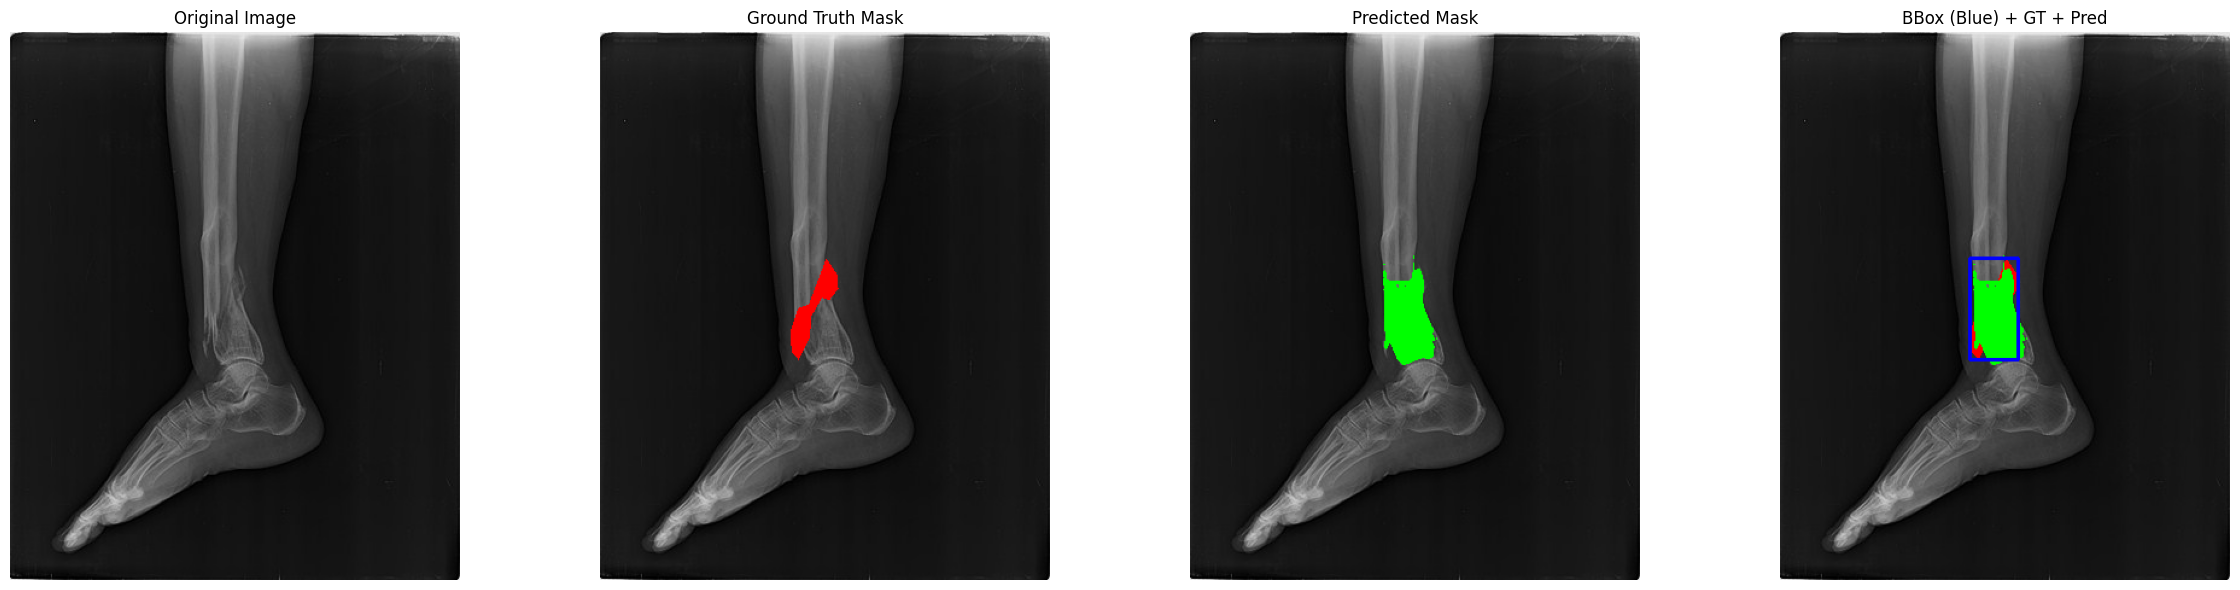

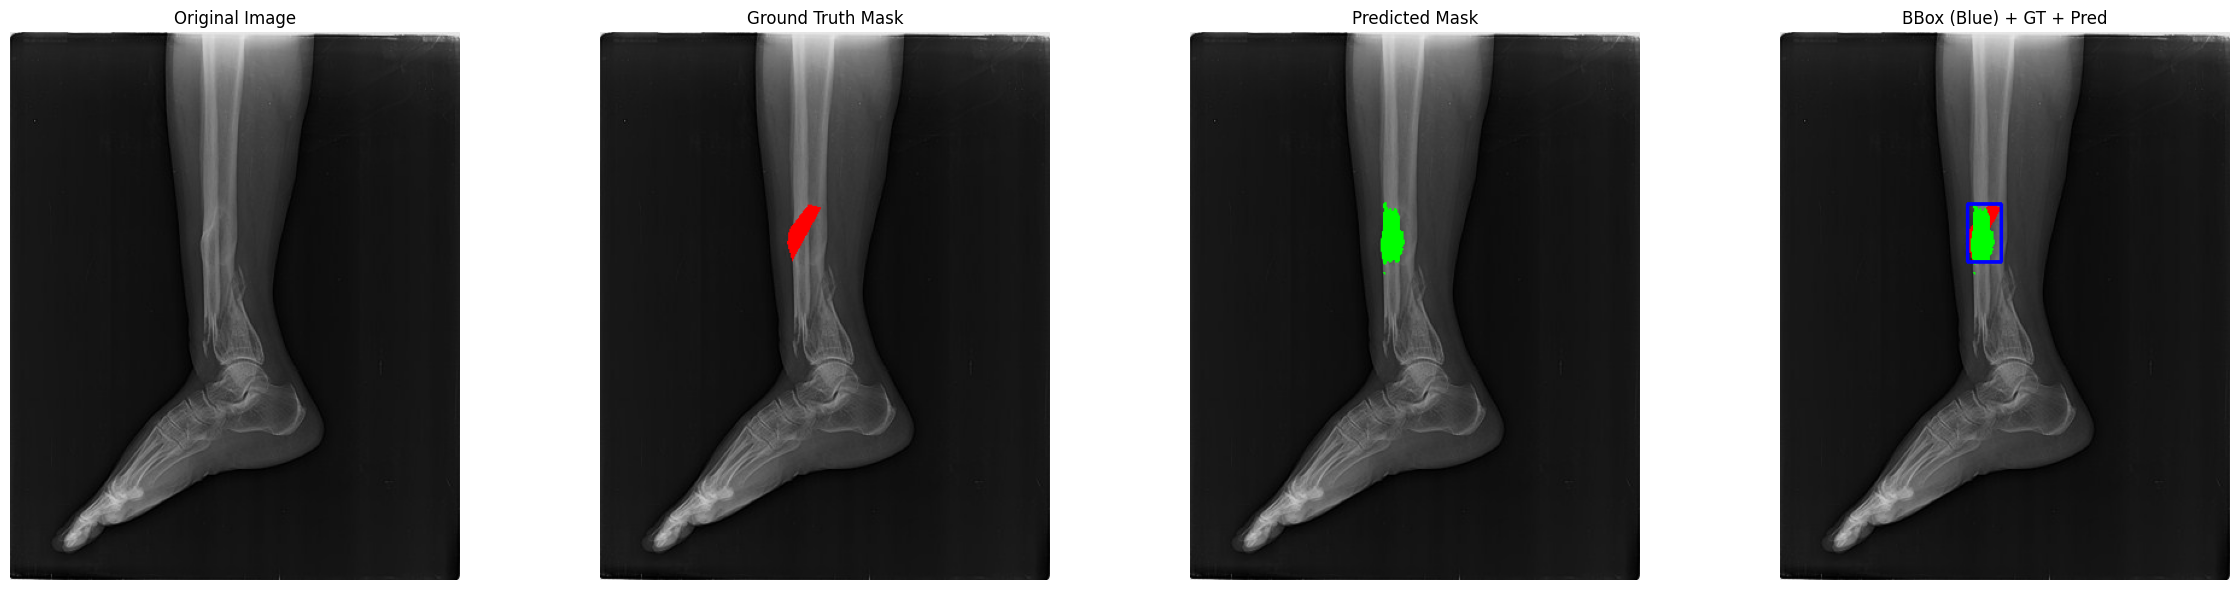

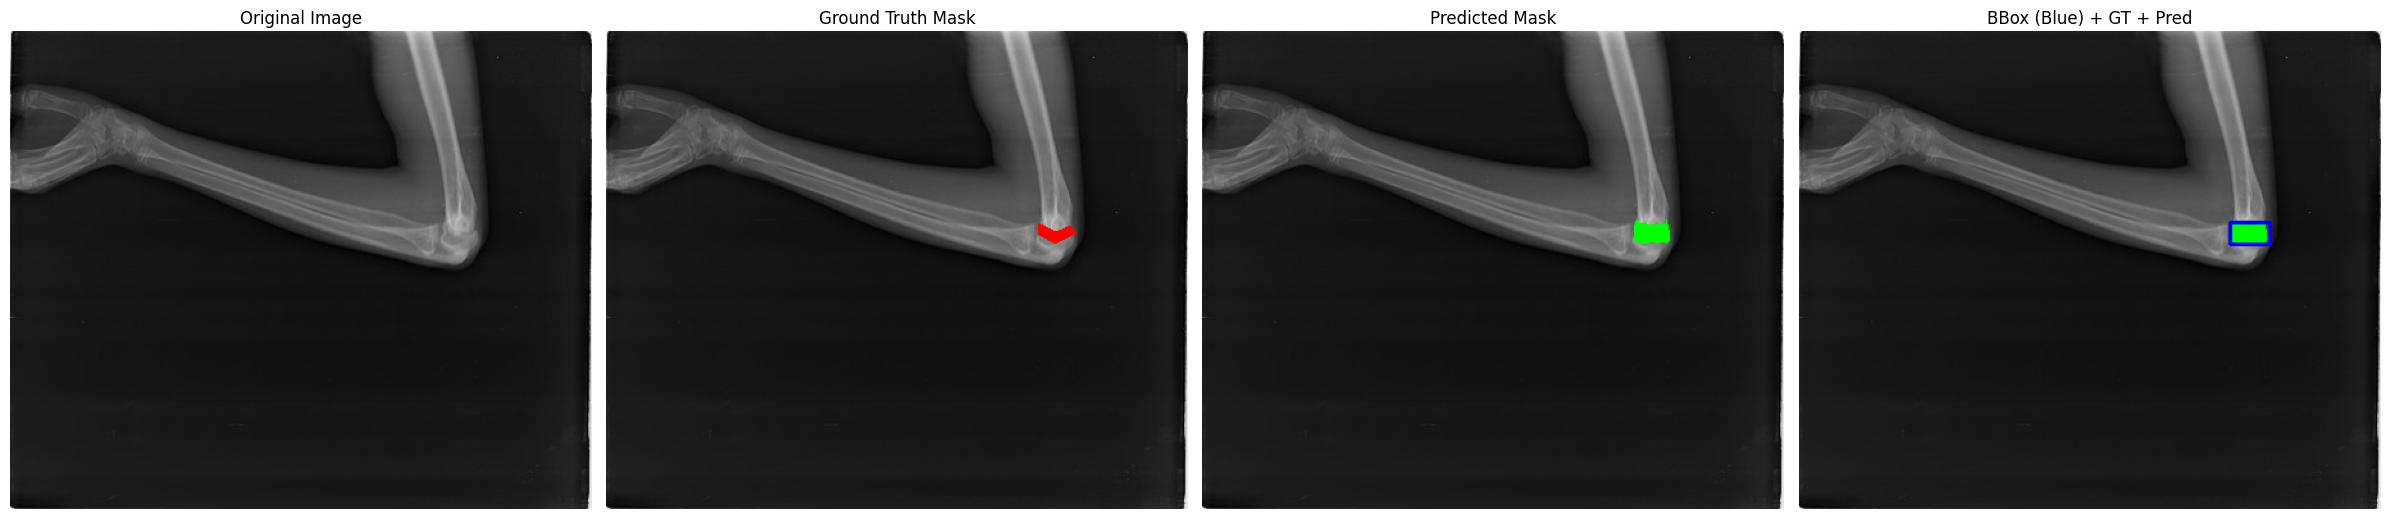

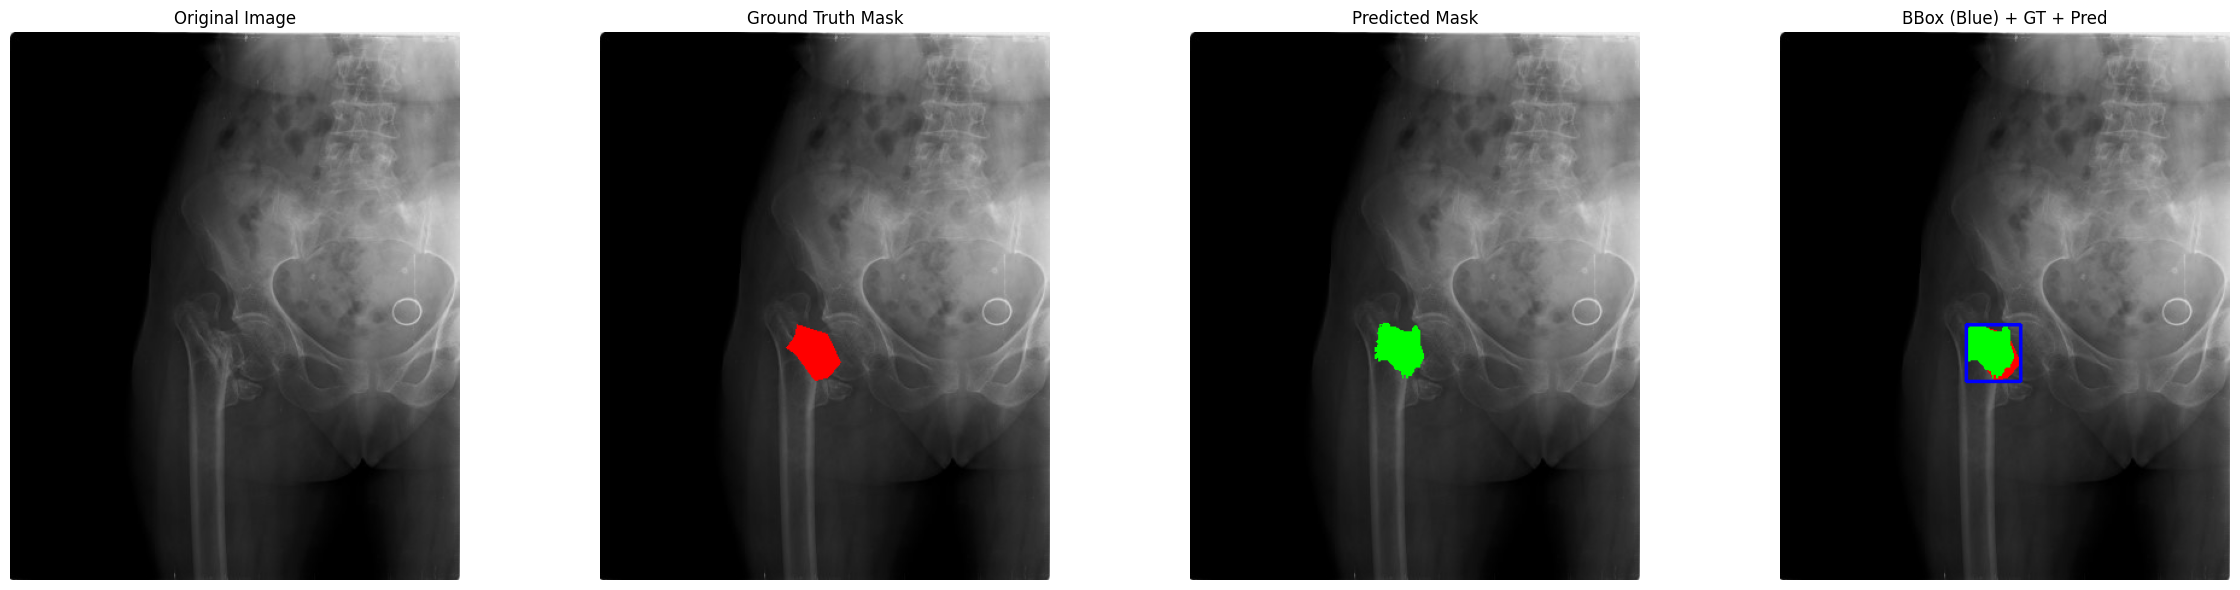

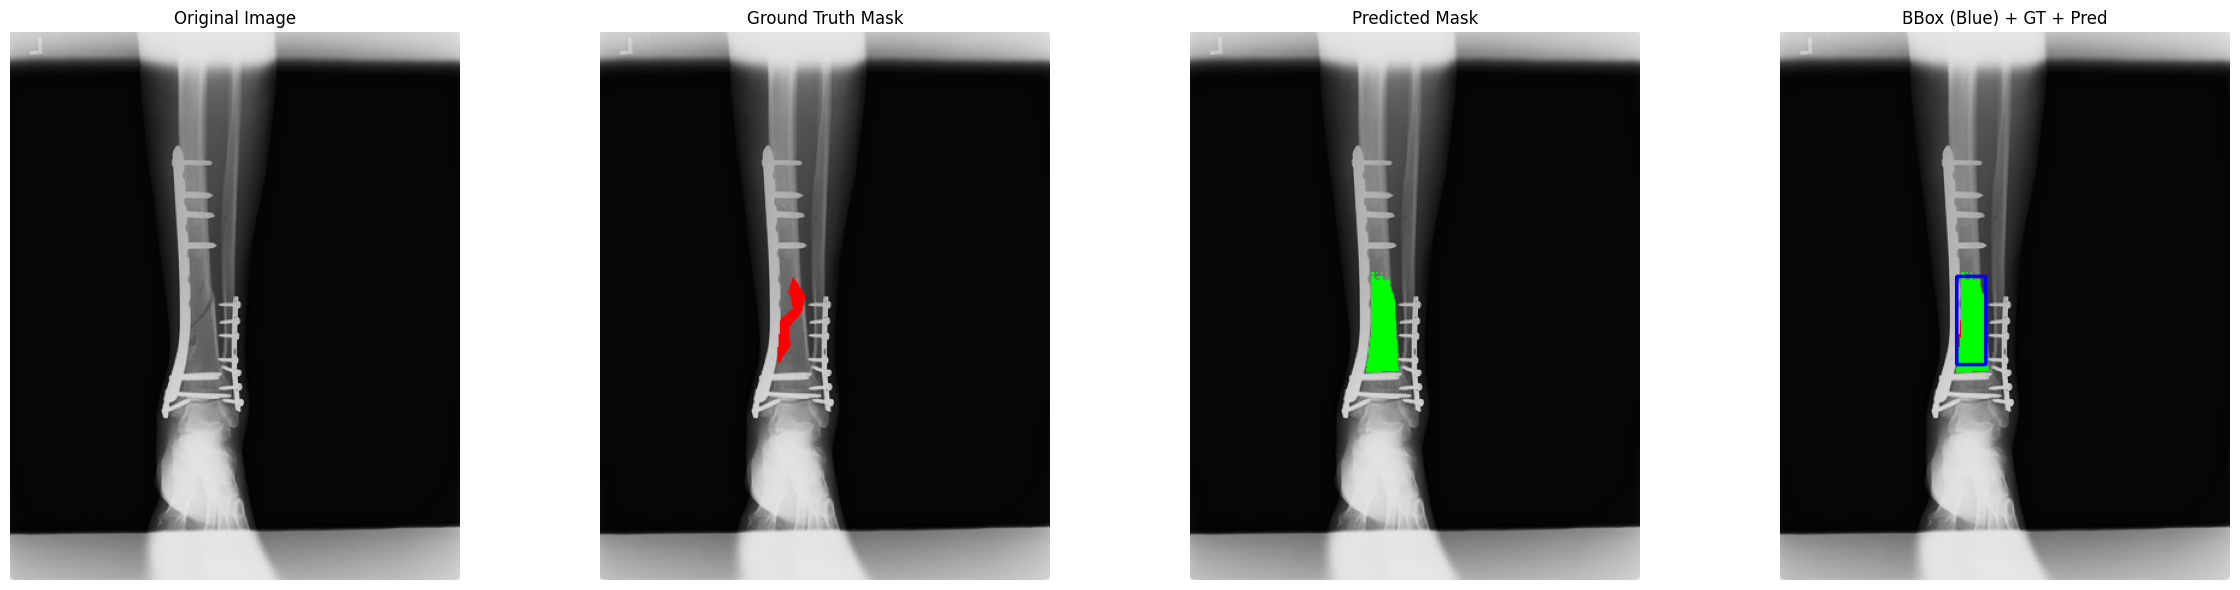

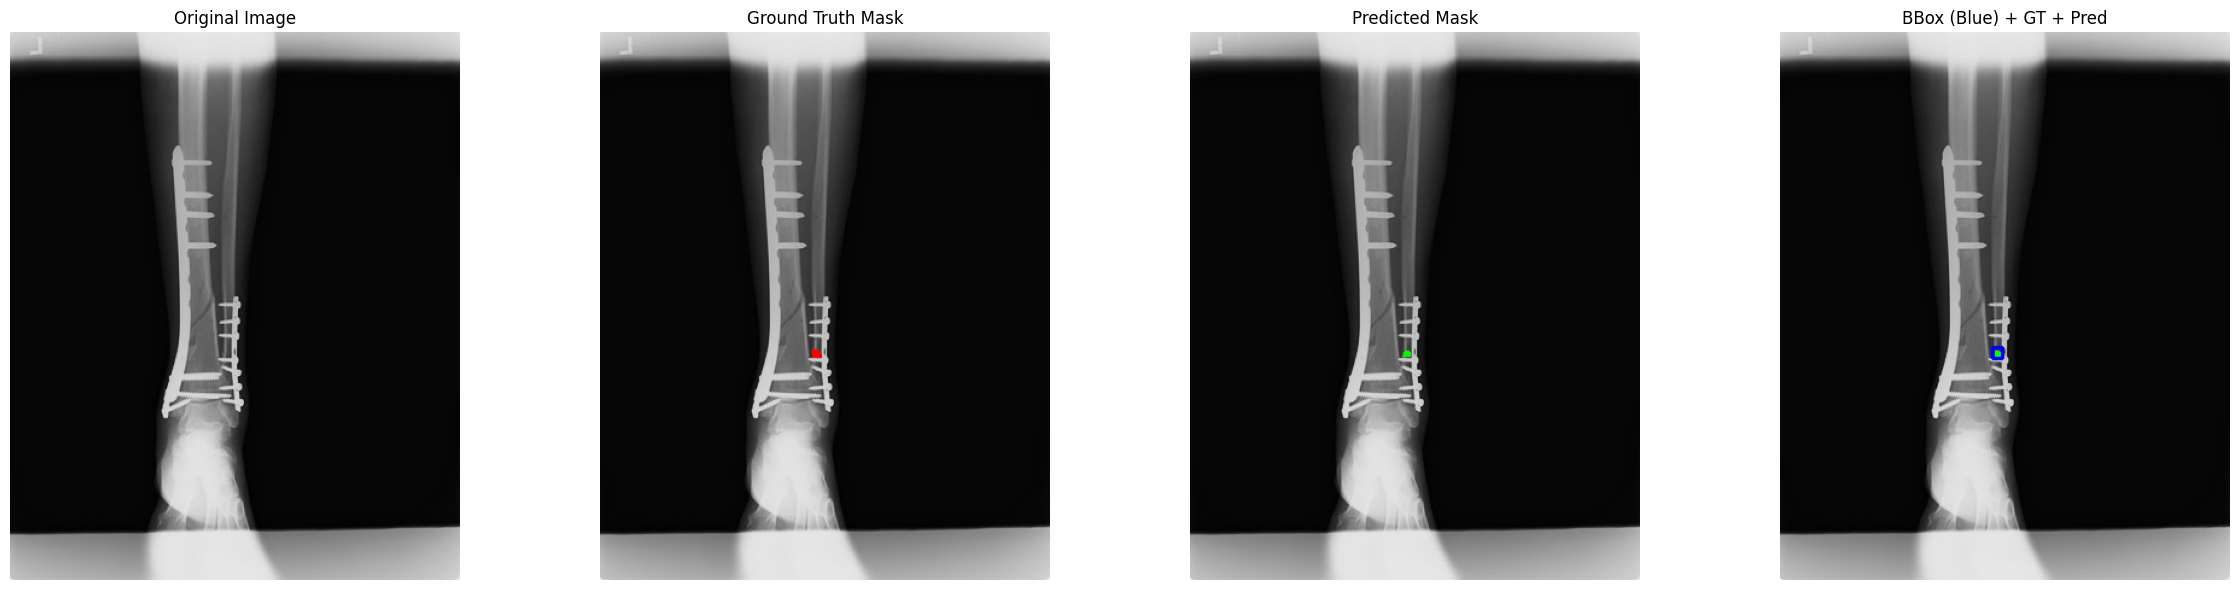

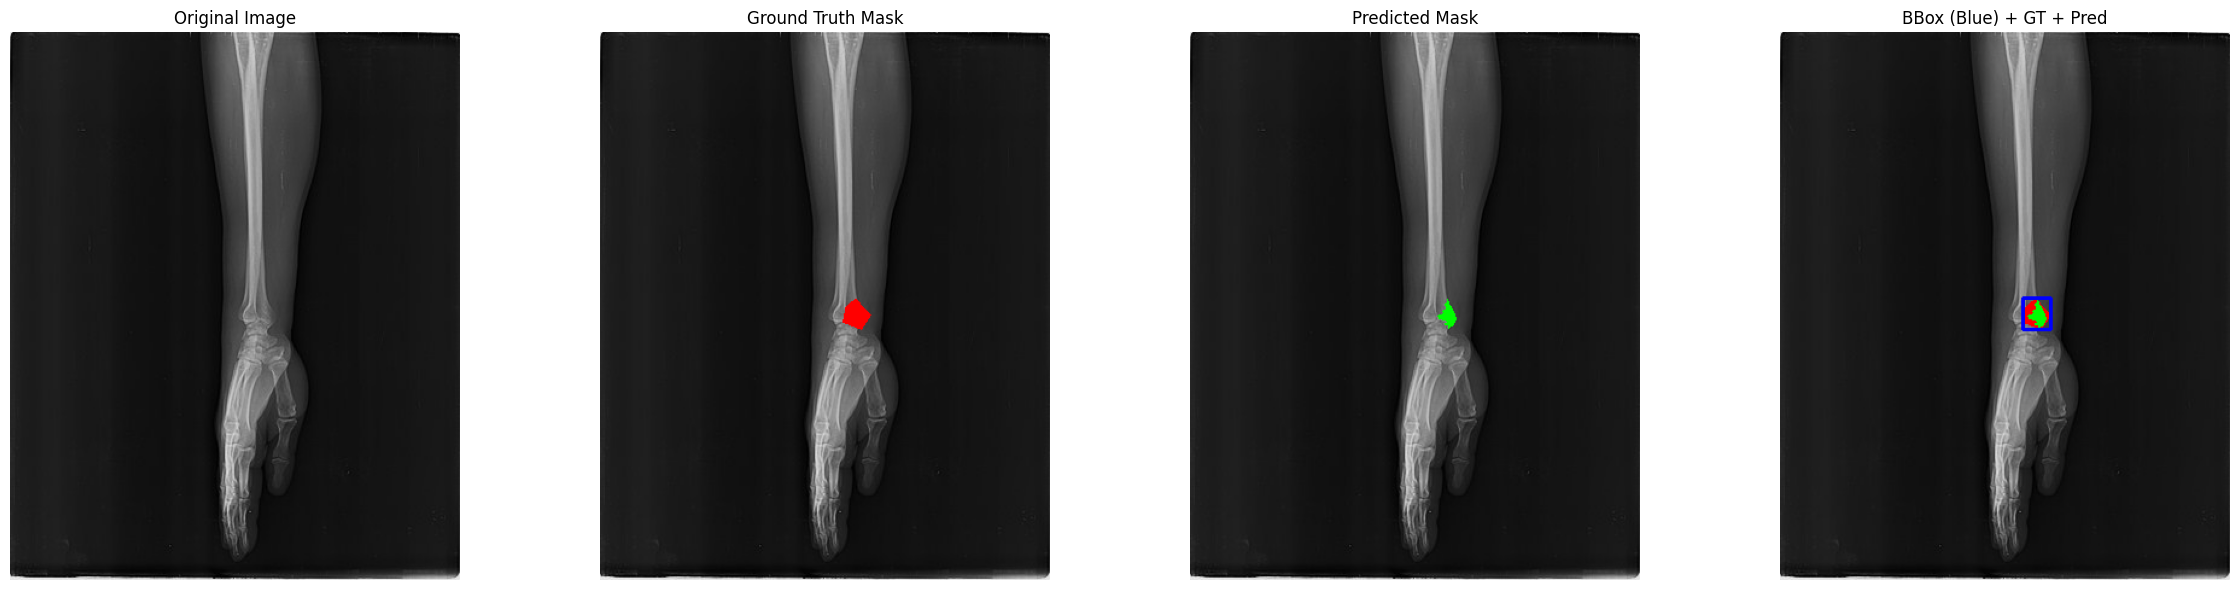

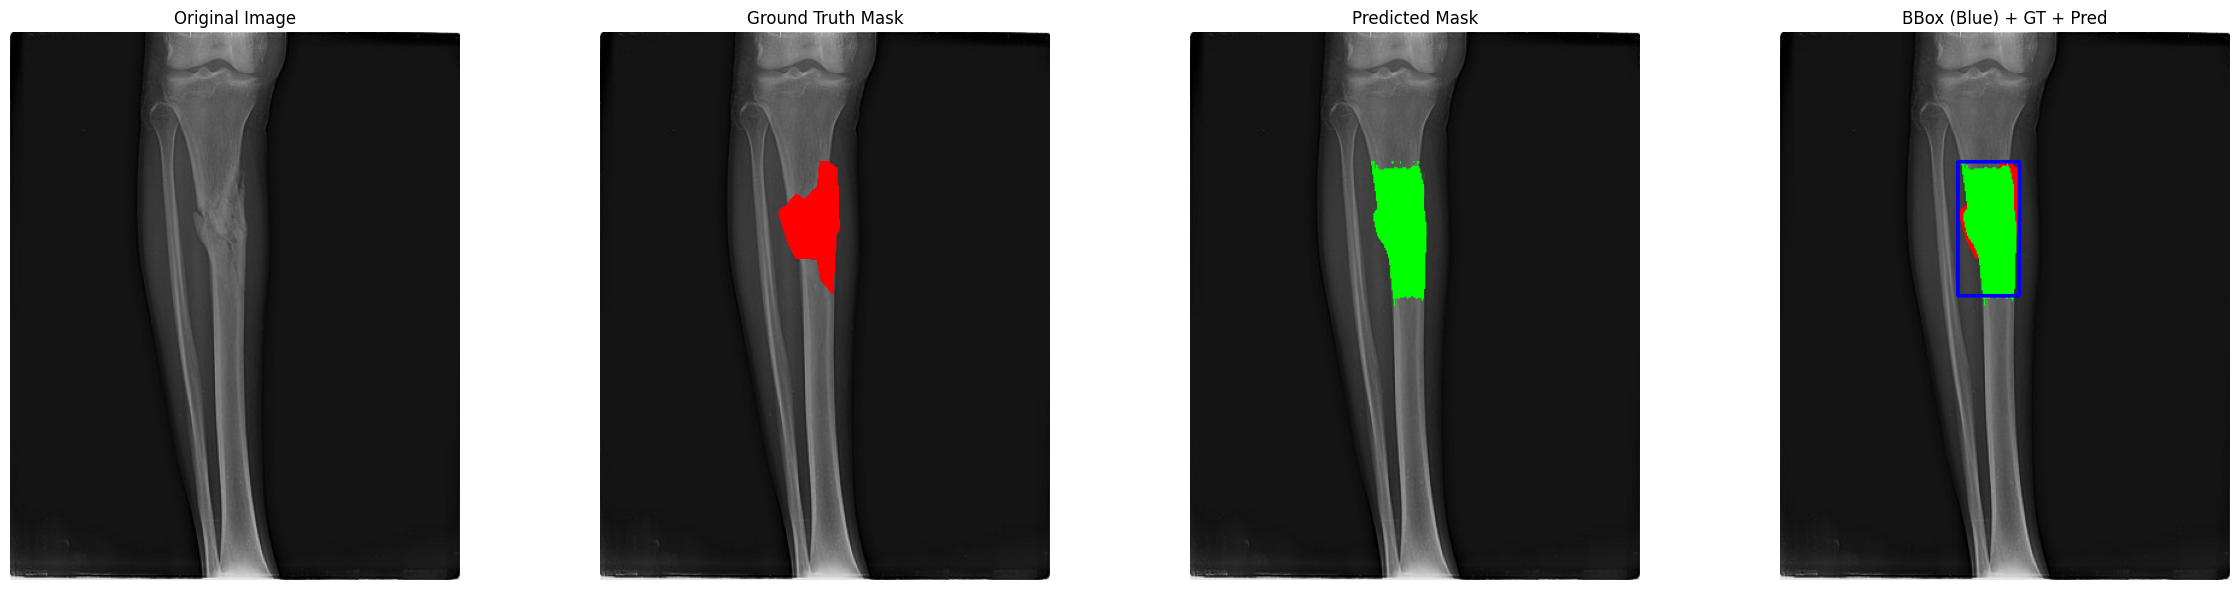

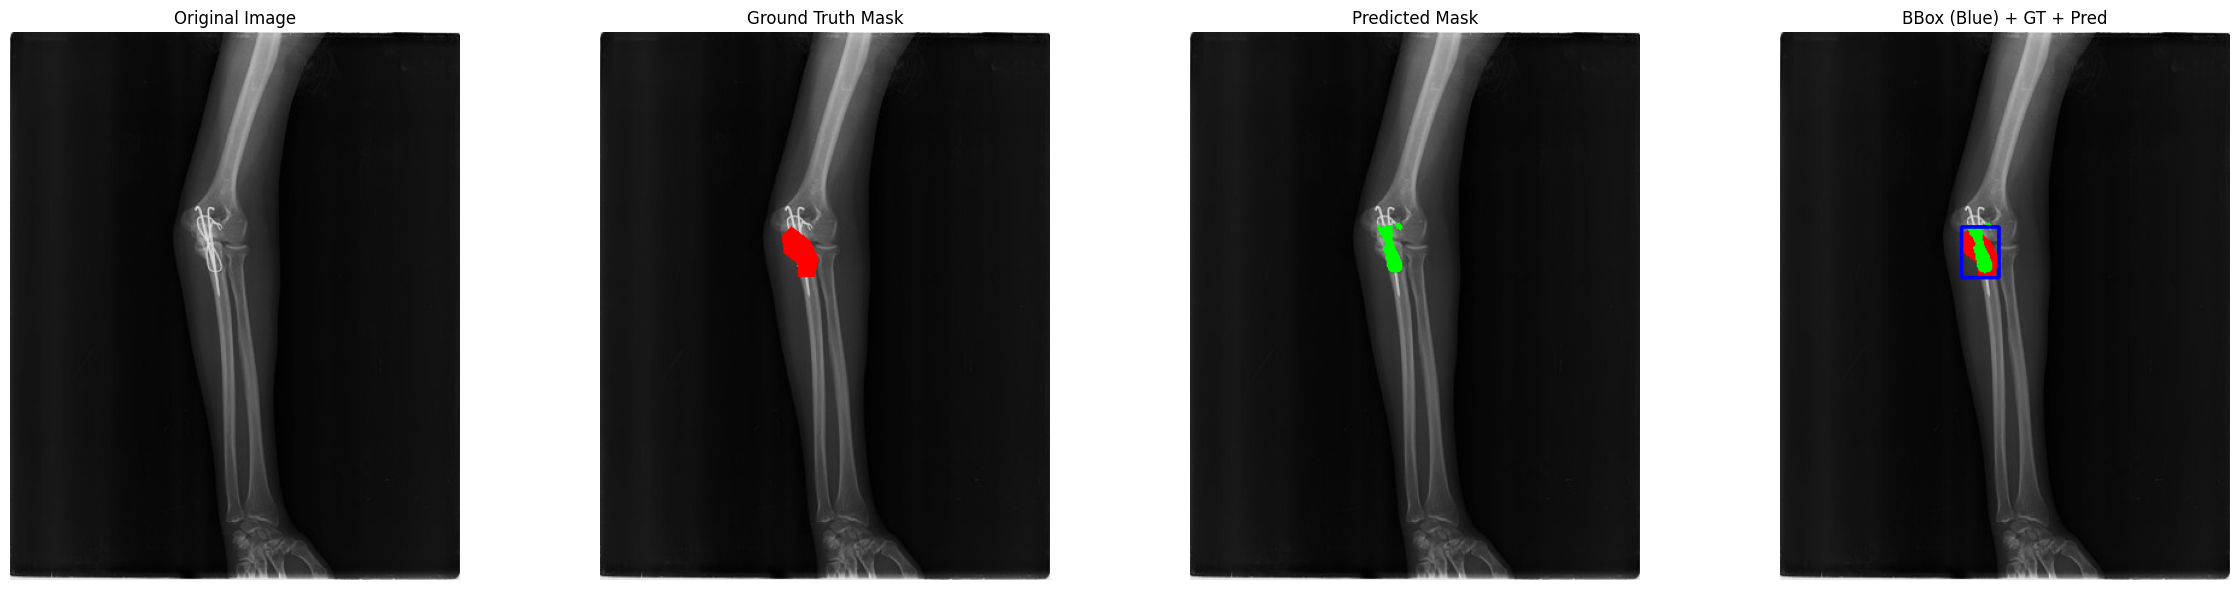

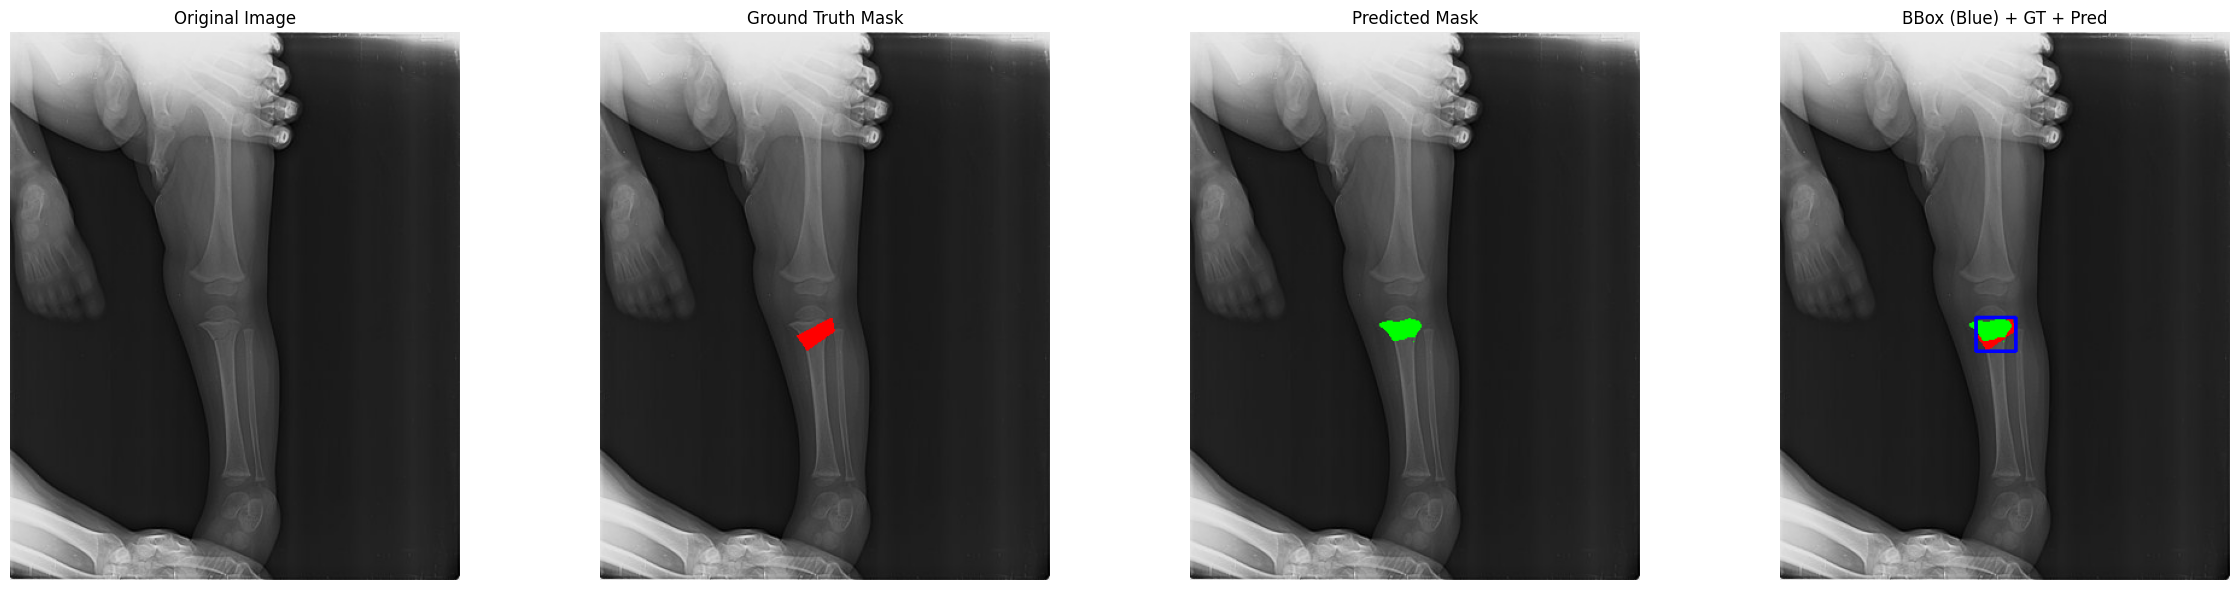

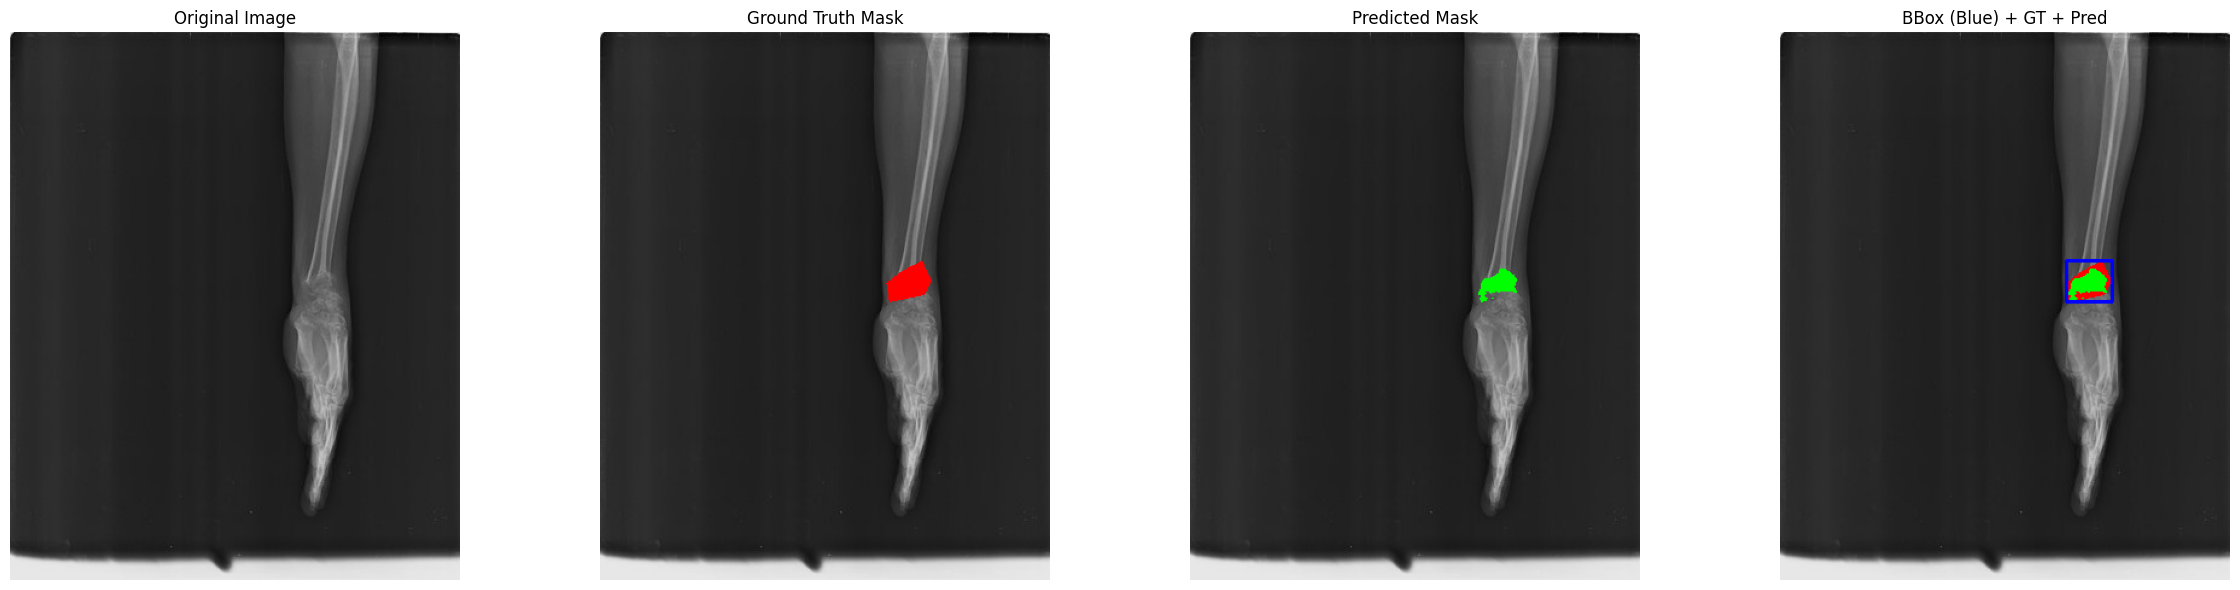

In [ ]:
for image_id in image_ids:
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(images_path, image_info["file_name"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=category_ids)
    annotations = coco.loadAnns(annotation_ids)

    for annotation in annotations:
        gt_mask = coco_to_mask(coco, annotation, image.shape[:2])

        bbox = annotation["bbox"]
        input_box = np.array([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
        masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
        pred_mask = masks[0].astype(np.uint8)

        iou, precision, recall = evaluate_segmentation(gt_mask, pred_mask)
        iou_scores.append(iou)
        precision_scores.append(precision)
        recall_scores.append(recall)

        if (image_id - 1) % 50 == 0:
            visualize_overlays(image, gt_mask, pred_mask, input_box, image_id)

In [ ]:
mean_iou = np.mean(iou_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)

print(f"Mean IoU: {mean_iou:.2f}")
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")

Mean IoU: 0.69
Mean Precision: 0.88
Mean Recall: 0.77
